In [1]:
import numpy as np
np.seterr(all='ignore')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.size': 14})
#from scipy.integrate import quad,dblquad,nquad
from scipy.optimize import root_scalar
from timeit import default_timer as timer
#import multiprocessing as mp
#import vegas
#import jax.numpy as jnp
#from jax import grad
#import numba as nb

In [2]:
# Global constants
# light speed, cm
#c = 29979245800
c=3e10
# kpc to cm
#kpc2cm = 3.08567758149137e21
kpc2cm = 3.085e21
# erg to MeV
erg2MeV = 624150.913
# year in seconds
yr = 31536000
# Neutrino lumonisity, single specie
Lv = 3e52/6
tv = 1.02667e11
# distance between SN and Earth
R_MW = 8.5
R_LMC = 50

## SN neutrino and DM halo profile
The neutrino number density per energy
$$
\frac{dn_\nu}{dE_\nu}(r,E_\nu) = \sum_\beta \frac{L_{\nu_{\beta}}}{4\pi r^2 c \langle E_{\nu_\beta}\rangle}f_{\nu_\beta}(E_{\nu_\beta})
$$
where $\beta$ indicates the neutrino flavor and
$$
f_{\nu_\beta}(E_{\nu_\beta}) = \frac{1}{F_2(\eta_\nu)}\frac{1}{T_{\nu_\beta}^3}\frac{E_{\nu_\beta}^2}{\exp(E_{\nu_\beta}/T_{\nu_\beta} -\eta_\nu)+1}
$$
and in general $\eta_\nu=3$ for all flavor $\beta$ and $F_2(\eta_\nu)\approx 18.96$.

NFW DM density profile
$$
n_\chi(r)=\frac{\rho_\chi}{m_\chi}\frac{1}{\frac{r}{r_s}(1+\frac{r}{r_s})^2}
$$
where $\rho_\chi = 184\,{\rm MeV/cm}^3$ and $r_s=24.42\,{\rm kpc}$.

In [3]:
def dnv(r,Ev,Lv=Lv):
    """
    Neutrino number density per energy at r
    
    Input
    ------
    Enu: Neutrino energy in MeV
    r: Distance to the SN explosion site, in cm
    Lv: Neutrino luminosity, default is 1e52 erg/s, total time is 10 second
    
    Output
    ------
    Neutrino flux at r: # per Enu per cm**3 per second
    """
    Lv = Lv*erg2MeV
    r = r*kpc2cm
    
    def _fv(Ev,Tv):
        """
        Fermi-Dirac distribution
        """
        exponent = Ev/Tv - 3
        # setup a cutoff value when the exponent beyon the validatiy of float64
        if exponent <= 709.782:
            return (1/18.9686)*Tv**(-3)*(Ev**2/(np.exp(exponent)+1))
        else:
            return 0
    
    nue_dist = _fv(Ev,2.76)/11
    nueb_dist = _fv(Ev,4.01)/16
    # total 4 species for x
    nux_dist = _fv(Ev,6.26)/25
    
    L=Lv/(4*np.pi*r**2*c)
    return L*(nue_dist+nueb_dist+4*nux_dist)


def nx(r,mx,kind='MW'):
    """
    DM number density at r
    
    Input
    ------
    r: distance to GC, in cm
    mx: DM mass in MeV
    kind: string, MW or LMC
    
    Output
    ------
    DM number density, #/cm^3 at r
    """
    if kind == 'MW':
        rho,rs,n = 184,24.42,2
    elif kind == 'LMC':
        rho,rs,n = 68,31.9,3
    rr=r/rs
    return (rho/mx)/(rr*(1+rr)**n)

## DM emissivity

Upscattered DM emissivity
$$
j_\chi^N(r,p_\chi,\alpha)=\frac{dn_\chi}{dtdp_\chi d\Omega_\alpha}=\frac{dn_\chi}{dtdE_\nu d\Omega_\alpha}\frac{dE_\nu}{dp_\chi}=c\sigma_{\chi \nu}n_\chi(r)\frac{dn_\nu}{dE_\nu}g(\alpha,E_\nu)\frac{dE_\nu}{dp_\chi},
$$
where $g(\alpha,E_\nu)$ is the angular distribution of the upscattered DM, $p$ the upscattered DM momentum and $\alpha$ the scattering angle.

The angluar distribution is given by
$$
g(\alpha,E_\nu)=\frac{dn_\chi}{d\Omega_\alpha}=\frac{\sin[2\tan^{-1}(\gamma \tan\alpha)]}{2\pi \sin\alpha}\frac{\gamma \sec^2\alpha}{1+\gamma^2\tan^2\alpha}=\frac{\gamma^2}{\pi}\frac{\sec^3\alpha}{(1+\gamma^2\tan^2\alpha)^2} = \frac{\gamma^2}{\pi}\frac{r^3\sqrt{r^2-R^2\sin^2\theta}}{(r^2+R^2(\gamma^2-1)\sin^2\theta)^2}
$$
and satisfies the normalization condiation
$$
\int g(\alpha,E_\nu)d\cos\alpha d\phi =1
$$
where $\alpha$ runs from $0$ to $\pi/2$ and $\gamma=E_\chi/m_\chi$. As a matter of fact, the above condition is irrelevant to $\gamma$.

### Find $E_\nu$ with given $T_\chi$ and $\alpha$

We re-express $p_\chi$ in terms of kinetic energy $T_\chi$ via
$$
p_\chi = \sqrt{T_\chi(T_\chi+2m_\chi)}\to dp_\chi = \frac{T_\chi + m_\chi}{\sqrt{T_\chi(T_\chi+2m_\chi)}}dT_\chi \equiv \frac{dT_\chi}{v_\chi(T_\chi,m_\chi)}
$$
thus
$$
\frac{dE_\nu}{dp_\chi}= v_\chi(T_\chi,m_\chi)\frac{dE_\nu}{dT_\chi}\quad {\rm and}\quad \frac{dE_\nu}{dp_\chi}dp_\chi=\frac{dE_\nu}{dT_\chi}dT_\chi.
$$
In the limits of non-relativistic $T_\chi \ll m_\chi$ and of relativistic $T_\chi \gg m_\chi$, they have $v_\chi\to \sqrt{2T_\chi/m_\chi}$ and $v_\chi \to 1$ respectively as expected. Note that the relation between $E_\nu$ and $T_\chi$ can be determined by
$$
T_\chi = \frac{E_\nu^2}{E_\nu+m_\chi/2}\left(\frac{1+\cos\theta_c}{2}\right)
$$
and
$$
\theta_c = 2\tan^{-1}(\gamma \tan\alpha)
$$
where $\gamma = E_{\chi,{\rm cm}}/m_\chi$. Once $\alpha$ and $T_\chi$ are given, $E_\nu$ will be specified, hence numerically we have
$$
\frac{dE_\nu}{dT_\chi} =\underset{dT_{\chi}\to 0}{\lim} \frac{E_\nu(T_\chi+dT_\chi,\alpha)-E_\nu(T_\chi,\alpha)}{dT_\chi}.
$$
We can obtain $E_\nu$ with given $T_\chi$ and $\alpha$ through *root finding method*.

An alternative way is to derive the *analytical expression* of $E_\nu$ in terms of $T_\chi$,
$$
E_{\nu}=\frac{T_{\chi}\sec^{2}\alpha+\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}{2-T_{\chi}\tan^{2}\alpha/m_{\chi}}=\frac{T_{\chi}m_{\chi}}{\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})\left(1-\frac{R^{2}}{r^{2}}\sin^{2}\theta\right)}-T_{\chi}}
$$
where $\gamma$ can be expressed in terms fo $E_\nu$ and $m_\chi$ by
$$
\gamma=\frac{E_{\chi,{\rm cm}}}{m_\chi}=\frac{s+m_\chi^2}{2\sqrt{s}}\frac{1}{m_\chi}=\frac{E_\nu +m_\chi}{\sqrt{m_\chi(2E_\nu + m_\chi)}}.
$$
It is obvious that the numerator of $E_\nu$ is always positive but the denominator is not when $2<T_\chi \tan^2\alpha/m_\chi$. Thus $E_\nu$ will turn negative and becomes unphysical. For the given $\alpha$ and $m_\chi$, the allowed range is $T_\chi < 2m_\chi/\tan^2\alpha$. There is another root for $E_\nu$ but it is always negative.

Thus we have the differential
$$
\frac{dE_\nu}{dT_\chi}= \frac{m_{\chi}^{2}\sec\alpha(2\sec\alpha\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}+2m_{\chi}+T_{\chi}\sec^{2}\alpha+T_{\chi})}{(T_{\chi}\tan^{2}\alpha-2m_{\chi})^2\sqrt{T_{\chi}(2m_{\chi}+T_{\chi})}}=\frac{m_{\chi}^{2}\left(\frac{2\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}}{\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}}+2m_{\chi}+\frac{T_{\chi}}{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}+2T_{\chi}\right)}{\sqrt{T_{\chi}\left(2m_{\chi}+T_{\chi}\right)}\sqrt{1-\frac{R^{2}\sin^{2}\theta}{r^{2}}}\left(\frac{R^{2}\sin^{2}\theta T_{\chi}}{r^{2}-R^{2}\sin^{2}\theta}-2m_{\chi}\right){}^{2}}
$$
No matter it is through root finding or analytical expression, both results should agree with each other.

In [4]:
def gamma(Ev,mx):
    """
    Calculate gamma factor in CM frame
    """
    s = mx**2+2*Ev*mx
    Ecm = 0.5*(s+mx**2)/np.sqrt(s)
    return Ecm/mx


def g(Ev,mx,alpha):
    """
    Calculate BDM angular distribution dndOmega
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    g: PDF of scattering angle alpha
    """ 
    if 0 <= alpha <= np.pi/2 and Ev > 0:
        gm = gamma(Ev,mx)
        sec = 1/np.cos(alpha)
        dndOmega = gm**2*sec**3/np.pi/(1+gm**2*np.tan(alpha)**2)**2
    else:
        dndOmega = 0
    return dndOmega


def Tx(Ev,mx,alpha):
    """
    Calculate DM kinetic energy, Eq. (28), and velocity, Eq. (30),
    in terms of lab frame scattering angle
    
    Input
    ------
    Enu: Neutrino energy
    mx: DM mass
    alpha: lab frame scattering angle in [0,Pi/2]
    
    Output
    ------
    Tx: DM kinetic energy at alpha after scattering
    """
    # gamma factor in CM frame
    gm = gamma(Ev,mx)
    # CM frame scattering angle
    theta_c = 2*np.arctan(gm*np.tan(alpha))
    
    # Tmax in lab frame
    Tmax = Ev**2/(Ev+0.5*mx)
    Tchi = 0.5*Tmax*(1+np.cos(theta_c))
    return Tchi


def Ev(Tx,mx,alpha):
    """
    Calculate the neutrino energy to produce DM kinetic energy at
    lab frame with scattering angle alpha via analytical expression.
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    Ev: the corresponding neutrino energy
    """ 
    sec = 1/np.cos(alpha)
    Enu = (Tx*sec**2+sec*np.sqrt(Tx*(2*mx+Tx)))/(2-Tx*np.tan(alpha)**2/mx)
    return Enu


def dEv(Tx,mx,alpha):
    """
    Calculate dEv/dTx via analytical expression. Note that the given
    inputs must lead to positive Ev or the corresponding dEvdTx would
    be unphysical
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    alpha: scattering angle in lab frame
    
    Output
    ------
    dEv/dTx: the derivative of Ev over Tx
    """
    sec = 1/np.cos(alpha)
    numerator = mx**2*sec*(2*sec*np.sqrt(Tx*(2*mx + Tx)) + 2*mx + Tx*sec**2 + Tx)
    denominator = (Tx*np.tan(alpha)**2 - 2*mx)**2*np.sqrt(Tx*(2*mx + Tx))
    return numerator/denominator


def vx(Tx,mx):
    """
    The dimensionless DM velocity. To restore the physical unit, just
    times the speed of light c
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    
    Output
    ------
    vx: dimensionless DM velocity
    """
    return np.sqrt(Tx*(Tx+2*mx))/(Tx+mx)


def xemissivity(Tx,mx,alpha,r,tau=10,Lv=Lv,kind='MW'):
    """
    BDM emissivity at shell r, note the returned result is divided by sigxv and dimensionless DM velocity
    
    Input
    ------
    Tx: DM kinetic energy, MeV
    mx: DM mass, MeV
    alpha: the scattering angle in lab frame
    r: the distance from the scattering point to GC, in cm
    tau: the duration of SN explosion, default 10 s
    Lv: neutrino luminosity during the SN explosion, default 1e52 erg/s
        note that the total luminosity released by a single SN explosion
        should be Lv times the duration of that explosion, where the unit
        per second will be eliminated from this procedure
    kind: string, MW or LMC
    
    Output
    ------
    BDM emissivity: in the unit of per cm^3 per second
    """
    # if Tx >= 2mx/tan(a)^2, Ev will turn negative (diverge at equal) which is unphysical
    if Tx < 2*mx/np.tan(alpha)**2:
        Enu = Ev(Tx,mx,alpha)
        dEdT = dEv(Tx,mx,alpha)
        jx = dnv(r,Enu,Lv)*g(Enu,mx,alpha)*dEdT*c*nx(r,mx,kind)*tau
    else:
        jx = 0
    return jx

In [16]:
alpha_ls = np.linspace(0,0.5,1000)
mx1 = 0.001
mx2 = 0.1
mx3 = 10
mx4 = 1000
#mx5 = 1000
Tx = 10
g1 = []
g2 = []
g3 = []
g4 = []
#g5 = []
#gls_01keV = []
for a in alpha_ls:
    g1.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx1,a*np.pi),mx1,a*np.pi))
    g2.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx2,a*np.pi),mx2,a*np.pi))
    g3.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx3,a*np.pi),mx3,a*np.pi))
    g4.append(2*np.pi*np.sin(a*np.pi)*g(Ev(Tx,mx4,a*np.pi),mx4,a*np.pi))
#    g5.append(2*np.pi*np.sin(a)*g(Ev(Tx,mx5,a*np.pi),mx5,a*np.pi))

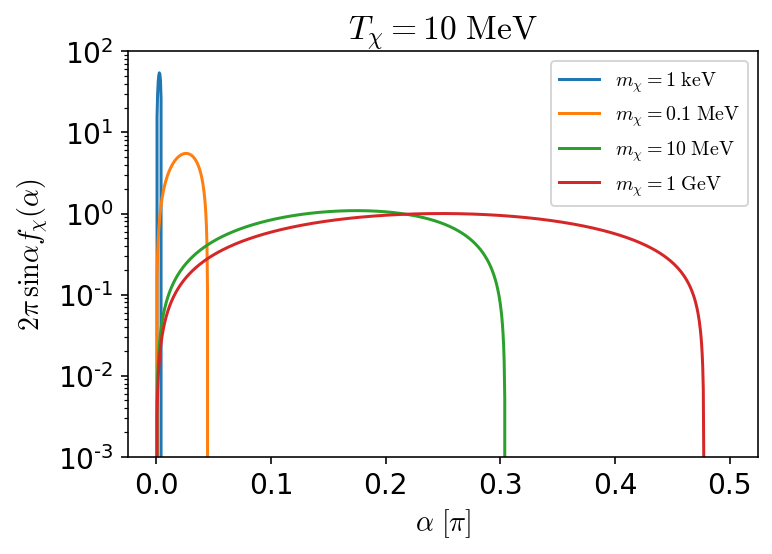

In [203]:
plt.figure(figsize=(5*1.13,3.3*1.13))
#ax = plt.gca() #you first need to get the axis handle
#ax.set_aspect(0.1) #sets the height to width ratio to 1.5. 
plt.plot(alpha_ls,g1,label=r'$m_\chi=1~{\rm keV}$')
plt.plot(alpha_ls,g2,label=r'$m_\chi=0.1~{\rm MeV}$')
plt.plot(alpha_ls,g3,label=r'$m_\chi=10~{\rm MeV}$')
plt.plot(alpha_ls,g4,label=r'$m_\chi=1~{\rm GeV}$')
#plt.plot(alpha_ls,g5,label='$m_\chi=$'+str(mx5)+' MeV')
plt.legend(loc='upper right',fontsize=10)
plt.xlabel(r'$\alpha~[\pi]$')
plt.ylabel(r'$2\pi\,\sin\alpha f_\chi (\alpha) $')
plt.title(r'$T_\chi =10~{\rm MeV}$')
plt.yscale('log')
plt.ylim(1e-3,100)
plt.savefig('fx.pdf',facecolor='white',bbox_inches='tight')

## Boosted DM flux at Earth

The upscattered DM flux is given by
$$
\frac{d\Phi^{N}(T_{\chi},t)}{dT_{\chi}dt}=2\pi \mathcal{J}\tau\int_{\cos\theta_{{\rm min}}}^{\cos\theta_{{\rm max}}}d\cos\theta \left. j_{\chi}^{N}(r,T_{\chi},\alpha)\right|_{\frac{r}{c}+\frac{\ell}{v_{\chi}}=t}
$$
where $\theta \in [0,\pi/2]$ and $\mathcal{J}$ is a Jacobian.
Once $t$ is given, the corresponding $r$ is also known for specified $\ell$ and $\cos\theta$ where
$$
r=\sqrt{\ell^2+R^2-2\ell R \cos\theta}
$$
hence after solving
$$
\frac{r}{c}+\frac{\ell}{v_\chi}=t
$$
we have (I used *Mathematica*)
$$
\ell = \frac{-\sqrt{c^{2}v_{\chi}^{2}(R^{2}-2Rtv_{\chi}\cos\theta+t^{2}v_{\chi}^{2})-R^{2}v_{\chi}^{4}\sin^{2}\theta}+c^{2}tv_{\chi}-Rv_{\chi}^{2}\cos\theta}{c^{2}-v_{\chi}^{2}}.
$$
Note that $t$ consists of two parts. The first counts from the propagation time of SN neutrino from the explosion site to the upscattering point $r/c$ (assuming neutrino carries light speed). The second indicates the DM propagation time from the upscattering point to the Earth $\ell/v_\chi$.
In addition, the Jacobian factor is derived as
$$
d\left(\frac{r}{c}+\frac{\ell}{v_\chi}\right)=dt\to \left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)d\ell = dt,
$$
Thus,
$$
\mathcal{J}=\left(\frac{\ell- R\cos\theta}{rc} +\frac{1}{v_\chi}\right)^{-1}.
$$

Some input, such as $t$, have no physical solutions for both $\ell$ and $r$ (one or both of them would be negative). Therefore the contribution from such $t$ to the emissivity $j_\chi^N$ should be removed manually.

Another trouble happens when we use $\sin\alpha =R\sin\theta/r$ to obtain $\alpha$. The two cases are degenerate $\sin\alpha = \sin(\pi-\alpha)$. *Numpy* function `arcsin` only returns $\alpha<\pi/2$ result, despite sometimes the true $\alpha$ is larger than $\pi/2$. So instead of using the law of sine, I implemented the law of cosine which will return the true $\alpha$ even it is larger than $\pi/2$. 

Since $\ell$ and $r$ are known, we have
$$
\cos(\pi-\alpha)=\frac{r^2+\ell^2-R^2}{2r\ell}
$$
thus
$$
\alpha =\cos^{-1}\left(\frac{R^2-r^2-\ell^2}{2r\ell}\right).
$$
The above guarantees the true $\alpha$ can be faithfully revealed.

<div align="center"> <img src="./geometry.png"> </div>

### Expression for $\ell$ with less error propagation in numerical evaluation
The following identity holds
$$
r + \frac{\ell}{v_\chi} = ct = c\left(\frac{R}{c}+t_{\rm input}\right) \equiv\zeta
$$
where $r$, $\ell$ and $\zeta$ are in normal length unit and $v_\chi$ the dimensionless velocity. Thus,
$$
\ell = \frac{v_\chi}{1-v_\chi^2}\left(\zeta-Rv_\chi\cos\theta -\sqrt{(R^2-\zeta^2)(1-v_\chi^2)+(Rv_\chi\cos\theta-\zeta)^2}\right)
$$
The above expression has less error due to we minimize the erroneous from the muplication of $\sin$ and $\cos$ in very small $\theta$.
Such error could further affect the later computation of $r$ and $\alpha$ due to they are all derived term from $\ell$.
A few percent fluctuation on $\ell$ will result in large change in $r$ in the region of $r\ll \ell$.

The prefactor $v_\chi/(1-v_\chi^2)=v_\chi/m_\chi$. This greatly reduces the error.

#### Legacy expression for $\ell$
The following simplified expression for $\ell$ is out-of-date due to large error propagation in numerical evaluation. But it is useful to keep it
as a comparasion.
$$
\ell = \frac{v_{\chi}}{1-v_\chi^2}\left(\zeta-Rv_{\chi}\cos\theta-\sqrt{R^{2}-R^{2}v_{\chi}^{2}+v_{\chi}^{2}\zeta^{2}+R_{\chi}v_{\chi}\cos\theta(Rv_{\chi}\cos\theta-2\zeta)}\right).
$$


### Vanishing BDM at time $t$
For a given $T_\chi$ and $m_\chi$, the vanishing of BDM flux vs. time $t$ corresponds to $g(\alpha)$ is too small to be relevant.
In principle $g(\alpha)$ vanishes when $\alpha=\pi/2$. But as one calculates, $g(\alpha)$ becomes too small to be detected even when $\alpha\ll\pi/2$ in the relativistic case.
Thus, we define an effective angle $\alpha_m$ that indicates $g(\alpha_m)$ touches the zero place (note that in such range $\alpha_m<\alpha<\pi/2$, $g(\alpha)$ is always $0$).
Thus following the law of sine,
$$
\frac{\ell}{\sin\Theta}=\frac{R}{\sin(\pi-\alpha_m)}=\frac{r}{\sin\theta}\to \frac{\ell}{\sin(\alpha_m-\theta)}=\frac{R}{\sin\alpha_m}=\frac{r}{\sin\theta}
$$
we express $\ell=R\sin(\alpha_m-\theta)/\sin\alpha_m$ and $r=R\sin\theta/\sin\alpha_m$. Hence,
$$
t=\frac{r}{c}+\frac{\ell}{v_\chi}=\frac{R}{\sin\alpha_m}\left(\frac{\sin\theta}{c}+\frac{\sin(\alpha_m-\theta)}{v_\chi}\right)
$$
and the maxima of $t$ happens when $\left. dt/d\theta\right|_{\theta=\theta_m}=0$. Generally, $\theta_m$ can be found numerically by solving the following identity,
$$
\frac{\cos(\alpha_m-\theta)}{\cos\theta}=\frac{v_\chi}{c}.
$$
Note that $\theta \in [0,\pi/2]$.

### Finding the $\theta_{\rm max}$ in the integral of $d\Phi_\chi/dT_\chi$

One can simply realize that for a given propagation time $t_{\rm \chi}$, the following identity holds
$$
t_\chi=\frac{r}{c}+\frac{\ell}{v_\chi}=\frac{R}{\sin\alpha}\left(\frac{\sin\theta}{c}+\frac{\sin(\alpha-\theta)}{v_\chi}\right).
$$
Therefore there are infinite solutions $(\alpha,\theta)$ that satisfy the above equation. Because we are solving a problem that has two unknown variables but only one constraint $t_\chi$.
The above equation has a tendency that when we increase $\alpha$, the associated $\theta$ corresponds to $t_\chi=0$ becomes larger.
Since we know that $\alpha$ exceeds $\alpha_m$ has no contribution, we can set the $\theta_m$ resulted from $\alpha_m$ from a given $t_\chi$ is the upper bound of the $\theta$-integral of $d\Phi_\chi/dT_\chi$.

In [5]:
def find_am(Tx,mx,th=1e-10,max_a=0.5*np.pi,show_info=False):
    """
    Find the first alpha that touches g(alpha) ~ 0 when 0 < alpha < pi/2
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    show_info: show message of the root algorithm
    
    Output
    ------
    show_info True: show all message
    show_info False: show the a_min only, in rad
    """
    bracket = [0,max_a]
    min_g = lambda alpha: g(Ev(Tx,mx,alpha),mx,alpha) - th
    a_m = root_scalar(min_g,bracket=bracket,method='brentq')
    if show_info:
        return a_m
    else:
        return a_m.root


def find_tmax(Tx,mx,th=1e-10,max_a=0.5*np.pi,R=R_MW):
    """
    Find the vanishing time of the BDM flux for a given Tx and mx
    
    Input
    ------
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    R: distance between Earth and SN at the center of (dwarf)galaxy, default is R_MW
    
    Output
    ------
    time: the vanishing time in second after the arrival of the first SN neutrino, in seconds
    """
    t0 = R*kpc2cm/c
    vdm = vx(Tx,mx)
    # am that leads to g(am)=0
    a_m = find_am(Tx,mx,th,max_a,False)
    # define the dt/dtheta = 0
    dtdth = lambda theta: np.cos(a_m - theta)/np.cos(theta) - vdm
    # finding theta_m that leads to dt/dtheta=0
    th_m = root_scalar(dtdth,bracket=[0, 0.5*np.pi],method='brentq').root
    t_max = ((np.sin(th_m) + np.sin(a_m - th_m)/vdm)/np.sin(a_m) - 1)*t0
    return t_max


def find_theta_bound(t,Tx,mx,th=1e-10,max_a=0.5*np.pi,R=R_MW):
    """
    Finding the integral bound for theta for given Tx, mx and arrival time
    
    Input
    ------
    t: the arrival time of BDM, origin is set to be the arrival of the first SN neutrino
        note that the input should not exceed the vanishing time lest error will occur
    Tx: DM kinetic energy
    mx: DM mass
    th: threshold
    max_a: upper bound for the range of alpha that the algorithm to search, default is pi/2
    R: distance between Earth and SN at the center of (dwarf)galaxy, default is R_MW
    
    Output
    ------
    tuple: lower and upper bound for theta in the integration, in rad
    """
    vdm = vx(Tx,mx)
    t0 = R*kpc2cm/c
    # find a_min
    a_m = find_am(Tx,mx,th,max_a,False)
    # find t_max
    t_max = find_tmax(Tx,mx,th=1e-10,max_a=0.5*np.pi,R=R_MW)
    
    if t<= t_max:
        pass
    else:
        t = t_max
        #print('Input t exceeds vanishing time, and is relocated at vanishing time')
    
    # We will use Newton-Raphson method to find the root that corresponds to theta_max
    # This method requires the target function _f and its derivative _fp
    def _f(theta):
        return np.sin(theta) + np.sin(a_m - theta)/vdm - (t/t0 + 1)*np.sin(a_m)
    
    def _fp(theta):
        return np.cos(theta) - np.cos(a_m - theta)/vdm
    
    # find solution to theta_max using Newton-Raphson method
    sol_theta_max = root_scalar(_f,method='newton',x0=np.pi/2,fprime=_fp)    
    if sol_theta_max.converged and 0 <= sol_theta_max.root <= np.pi/2:
        theta_M = sol_theta_max.root
    else:
        #theta_M= sol_theta_max
        raise ValueError('Something went wrong.')
        
    # find solution to theta_min using Newton-Raphson method
    sol_theta_min = root_scalar(_f,method='newton',x0=0,fprime=_fp)    
    if sol_theta_min.converged and 0 <= sol_theta_min.root <= theta_M:
        theta_m = sol_theta_min.root
    else:
        theta_m = 0
        
    return theta_m,theta_M


def theta_slice(theta_bound,slice_num=10,scale='log'):
    """
    Slicing the theta_bound into multiple integration range
    
    Input
    ------
    theta_bound: tuple, (theta_min,theta_max) from find_theta_bound
    slice_num: number of ranges to be sliced within the bound, default 10
    scale: string, the scale of range should be sliced into
        log: sliced into log-scale
        lin: sliced into linear-scale
    
    Output
    ------
    array: an array that contains the integration range
    """
    theta_m,theta_M = theta_bound
    
    if scale == 'log':
        if theta_m == 0.0:
            theta_ls = np.logspace(np.log10(theta_M/10**slice_num),np.log10(theta_M),slice_num)
            theta_ls[0] = theta_m
            return theta_ls
        else:
            theta_ls = np.logspace(np.log10(theta_m),np.log10(theta_M),slice_num)
        return theta_ls
    
    elif scale == 'lin':
        theta_ls = np.linspace(theta_m,theta_M,slice_num)
        return theta_ls
    
    else:
        raise ValueError('Option scale is not legal')

In [6]:
def find_lra(t,theta,vx,R=R_MW,r_cut=1e-5,dtype=None,legacy=False):
    """
    Find l, r and alpha when t, cos\theta, R and vx are given
    
    Input
    ------
    t: timing in seconds, 0 starts from the first arrival of the SN neutrino at Earth
        theta: in rad
    vx: dimensionless DM velocity, v/c
    R: distance between Earth and SN at the center of (dwarf)galaxy, default is R_MW
    r_cut: the inner most galactic region should be considered, default is 1e-5 kpc
    dtype: Manipulating the numeric with given precision: None or any dtype supported by
        numpy, eg., np.float128. Default is None
    legacy: legacy-style (out-of-date) for the l expression, which causes huge error
        propagation in the relativistic case. Simply for comparision, not for practical
        use
    
    Output
    ------
    tuple: (l,r,alpha,adopt)
           adopt is either True or False that indicates the results should be adopted
           or not
    """
    # expressing r_cut and R in cm
    r_cut = r_cut*kpc2cm
    R = R*kpc2cm
    # given the dtype in cos to increase the precision if necessary
    cos = np.cos(theta,dtype=dtype)
    zeta = R + c*t
    
    # evaluate l using new or legacy method
    if legacy is False:
        l = (zeta - R*vx*cos - np.sqrt((R**2-zeta**2)*(1-vx**2)+(R*vx*cos-zeta)**2))*vx/(1-vx**2)
    elif legacy:
        # calculate l with legacy method, which induces large error propagation for small theta
        # in relativistic case
        numerator = zeta-R*vx*cos-np.sqrt(R**2-(R*vx)**2+(vx*zeta)**2 + R*vx*cos*(R*vx*cos-2*zeta))
        denominator = 1-vx**2
        l = vx*numerator/denominator
    else:
        raise ValueError('Option legacy is not legal')
    
    # evaluate r-square and r for the given l
    r2 = l**2+R**2-2*l*R*cos
    r =  r2**0.5
    # the flag adopt will pass to bdmflux to indicate the set (r,l,alpha) should proceed evaluation or
    # set to zero directly
    if r>r_cut:
        # r does exceed the r-cutoff
        domain = (R**2-r2-l**2)/(2*r*l)
        if -1<= domain <= 1:
            # the domain is in the legal range then evaluate the corresponding alpha
            alpha = np.arccos(domain)
            adopt = True
            return l,r,alpha,adopt
        else:
            # the domain is not legal
            adopt = False
            return 0,0,0,adopt
    else:
        # r is smaller than the r-cutoff
        adopt = False
        return 0,0,0,adopt

    
def bdmflux(t,theta,Tx,mx,tau=10,sigxv=1e-45,Lv=Lv,R=R_MW,r_cut=1e-5,kind='MW',dtype=None,legacy=False):
    """
    Boosted DM flux at Earth, per cm^2 per second
    
    Input
    ------
    t: time in second, 0 starts from the arrival of SN neutrino
    theta: the open angle theta
    Tx: DM kinetic energy, in MeV
    mx: DM mass, in MeV
    tau: the duration of SN explosion, default 10 s
    sigxv: DM-neutrino scattering cross section, default 1e-45 cm^2
    Lv: SN neutrino luminosity, default 1e52 erg/s
    R: distance between Earth and SN at the center of (dwarf)galaxy, default is R_MW
    r_cut: the inner most galactic region should be considered, default is 1e-5 kpc
    kind: string, MW or LMC
    dtype: Manipulating the numeric with given precision: None or any dtype supported by
        numpy, eg., np.float128. Default is None
    legacy: legacy-style (out-of-date) for the l expression, which causes huge error
        propagation in the relativistic case. Simply for comparision, not for practical
        use
    
    Output
    ------
    BDM flux: in the unit of per cm^2 per second for a given t
    """
    # Dimensionless DM velocity
    vdm = vx(Tx,mx)
    # Get l,r,alpha,adopt
    l,r,alpha,adopt = find_lra(t,theta,vdm,R,r_cut,dtype,legacy)
    if adopt:
        J = c/((l - R*kpc2cm*np.cos(theta,dtype=dtype))/r + 1/vdm)
        return 2*np.pi*J*sigxv*xemissivity(Tx,mx,alpha,r/kpc2cm,tau,Lv,kind)*np.sin(theta,dtype=dtype)*vdm
    else:
        return 0

In [7]:
def show_timing(start,end):
    tot_time = end - start
    if tot_time//60 == 0:
        print('Total evaluation time: ' + f"{tot_time:.3f}" + ' seconds', end='\r')
    else:
        mins = int(tot_time//60)
        secs = int(tot_time%60)
        print('Total evaluation time: ' + str(mins) + 'm' + str(secs) + 's', end='\r')

## Flux and event number evaluation
Following we are going to use `vegas` to compute the BDM flux vs. time as well as the integrated event number with the aid of `multiprocessing` (as `mp`).

### BDM flux vs. time
`quad` can be as accurate as `vegas` in this case with efficiency much improved. One flaw is that `quad` needs to slice $\theta$ integration range into multiple regions to ensure its accuracy.
It is much easier to build `quad` integral so I relegate it into the *OBSOLETE* part.
To maximize the performance, I ask `mp` to acquire as many as available CPU cores I can get from the ASGC, it should be around 64 if you use jupyter.
Exact number of available cores can be retrieved by `mp.cpu_count()`.

In [117]:
# Compute BDM flux vs time with various mx

# timing for mp, start
start_time_mp = timer()

# How many CPU cores should be used for mp later
cpu_count = mp.cpu_count()

# specified DM profile and optional setup
kind = 'MW'
#kind = 'LMC'
if kind == 'MW':
    R_dist,dtype,neval = R_MW,None,5000
elif kind == 'LMC':
    R_dist,dtype,neval = R_LMC,None,10000

# BDM kinetic energy
Tx = 10

# mx in MeV
mx_ls = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
#mx_ls=[1e-3]
# how many time stamps to be evaluated for a given mx
time_stamps = 100

# empty list to store the results: time_stamp and BDM flux
bdm_vs_time_mx = []
bdm_time_ls = []

# total points of evaluation
p_eval = len(mx_ls)*time_stamps
p_remained = p_eval

# starting message
print('Total ' + str(p_remained) +' points to be calculated and '+str(cpu_count)+ ' CPU cores are using', end='\r')

for mx in mx_ls:
    # list for each time stamp in log-scale
    time_ls = np.logspace(1,np.log10(find_tmax(Tx,mx,R=R_dist)),time_stamps)
    
    # define a function for theta-integration using vegas
    # this function will return the BDM flux at given time in time_ls
    # this function will be passed to multiprocessing
    def theta_integration(t):
        # get the integral range for theta
        theta_min,theta_max = find_theta_bound(t,Tx,mx,R=R_dist)
        # define integral range in vegas
        theta_integrator = vegas.Integrator([[theta_min,theta_max]])
        theta_int_result = theta_integrator(lambda theta: bdmflux(t,theta[0],Tx,mx,R=R_dist,kind=kind,dtype=dtype), nitn=10, neval=neval)
        return theta_int_result.mean
    
    # initializing multiprocessing pooling
    pool = mp.Pool(processes=cpu_count)
    bdm_vs_time = pool.map(theta_integration,time_ls)
    
    # save the result
    bdm_vs_time_mx.append(bdm_vs_time)
    bdm_time_ls.append(time_ls)
    
    p_remained -= time_stamps
    print(str(p_remained) + ' out of ' + str(p_eval) +' points remained to be calculated......', end='\r')

# timing for mp, end time
end_time_mp = timer()
show_timing(start_time_mp,end_time_mp)
#print('Total ' +str(p_eval) + ' points of evaluation completed in ' + f"{end_time_mp-start_time_mp:.3f}" + ' seconds.', end='\r')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
# save the result
for i in range(len(mx_ls)):
    np.savetxt('./BDM_data/flux/'+kind+'/bdm_flux_Tx_'+str(Tx)+'_mx_'+str(mx_ls[i])+'.txt',np.asarray([bdm_time_ls[i],bdm_vs_time_mx[i]]).T,fmt='%.5e')

Text(0.5, 1.0, 'BDM flux: MW, $T_\\chi=$10 MeV')

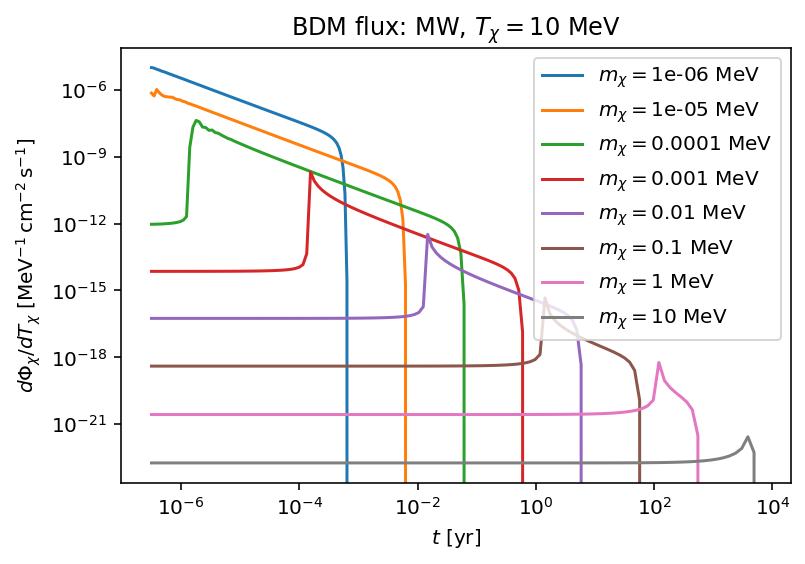

In [118]:
# plotting
for i in range(len(mx_ls)):
    plt.plot(bdm_time_ls[i]/yr,bdm_vs_time_mx[i],label='$m_\chi=$'+str(mx_ls[i])+' MeV')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi~[{\rm MeV^{-1}\,cm^{-2}\,s^{-1}}]$')
plt.title('BDM flux: '+kind+', $T_\chi=$'+str(Tx)+' MeV')
#plt.savefig('bdm_flux_'+kind+'_Tx_'+str(Tx)+'.pdf',facecolor='white',bbox_inches='tight')

### BDM event

To evaluate the integrated BDM event,
$$
N_\chi = \int_{10\,{\rm s}}^{30\,{\rm yr}} dt \int_{5\,{\rm MeV}}^{100\,{\rm MeV}} dT_\chi \frac{d\Phi_\chi}{dT_\chi},
$$
I suggest using `vegas`. It is much more accurate, fast and easier to implant than `quad`. Below is parallized over various $m_\chi$.
The integration ranges: $\theta$, time $t$ and $T_\chi$ are specified to fufill our needs in this project.

In [657]:
# Evaluate BDM event rate, \int dt dTx
# This is for SK, projected with 35 years

# timing
start_time_int_mp = timer()

# number of cpu cores
cpu_count = mp.cpu_count()
#cpu_count = 1
# specified DM profile and optional setup
kind = 'LMC'
dtype,neval = None,20000
R_ls = np.logspace(0,2,cpu_count)
# kinetic energy range to be integrated
Tx_min,Tx_max = 5,100

# how many mx should be evaluated, it is chosen to equal the available CPU cores
#mx_ls = np.logspace(-6,2,200)
mx_ls = [1e-3]
# initial time and maximum exposure time
t_ini,t_exp = 10,35*yr

def bdm_int(R_dist,mx=1e-3):
    mx_bdm_int = []
    #for Tx in Tx_ls:
    theta_m,theta_M=find_theta_bound(t_ini,Tx_max,mx,R=R_dist)
    t_max = find_tmax(Tx_min,mx,R=R_dist)
    # restrict t_max below maximum exposure time
    if t_max > t_exp:
        t_max = t_exp
    else:
        pass
    theta_integ = vegas.Integrator([[t_ini,t_max],[theta_m,theta_M],[Tx_min,Tx_max]])
    int_result = theta_integ(lambda x: bdmflux(x[0],x[1],x[2],mx,R=R_dist,kind=kind,dtype=dtype), nitn=10, neval=neval)
    return int_result.mean

pool = mp.Pool(processes=cpu_count)
#bdm_event = pool.map(bdm_int, mx_ls)
bdm_event = pool.map(bdm_int, R_ls)
end_time_int_mp = timer()

print('Total ' + f"{end_time_int_mp-start_time_int_mp:.3f}" + ' seconds for ' + str(len(mx_ls)) + ' DM masses', end='\r')

Text(0.5, 0, '$d$ [kpc]')

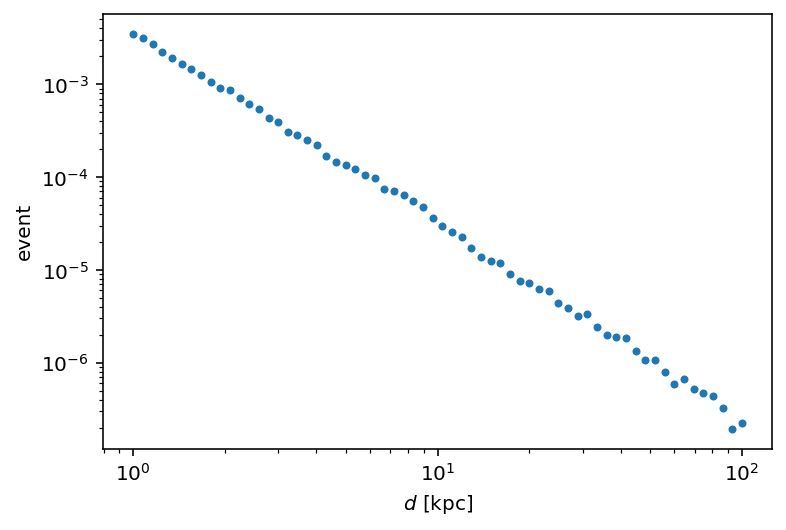

In [658]:
plt.plot(R_ls,bdm_event,'.')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('event')
plt.xlabel(r'$d$ [kpc]')
#plt.set_aspect('equal')

In [659]:
(np.log10(bdm_event[37])-np.log10(bdm_event[0]))/(np.log10(R_ls[37])-np.log10(R_ls[0]))

-2.0823665805065983

In [623]:
np.log10(R_ls[10])-np.log10(R_ls[5])

0.17336428615673666

In [660]:
power_ls =[]
for i in range(63):
    power = (np.log10(bdm_event[i+1])-np.log10(bdm_event[i]))/(np.log10(R_ls[i+1])-np.log10(R_ls[i]))
    power_ls.append(power)

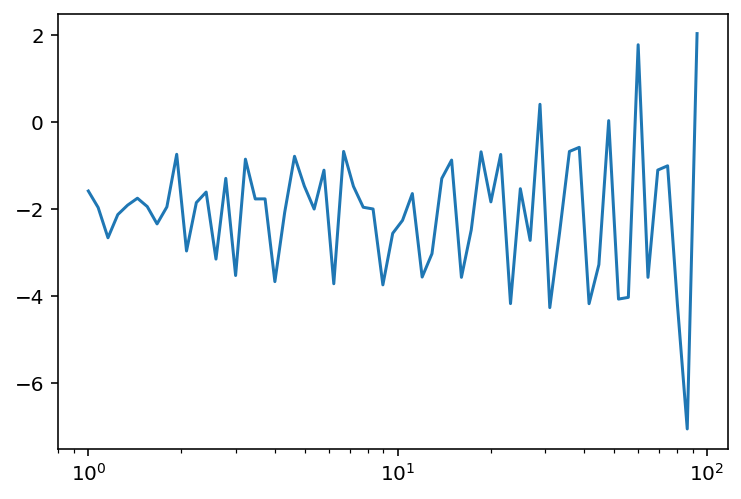

In [661]:
plt.plot(R_ls[:-1],power_ls)
plt.xscale('log')

In [19]:
(1/vx(10,1e-6)-1)*8.5*kpc2cm/c

0.004463966233695752

In [609]:
(R_ls[15]/R_ls[16])**(-3)

1.199462890625

NameError: name 'R' is not defined

In [272]:
# save the result
np.savetxt('./BDM_data/event_number/'+kind+'/event_vs_mx.txt',np.asarray([mx_ls,bdm_event]).T,fmt='%.5e')

Text(0.5, 1.0, 'BDM event: MW')

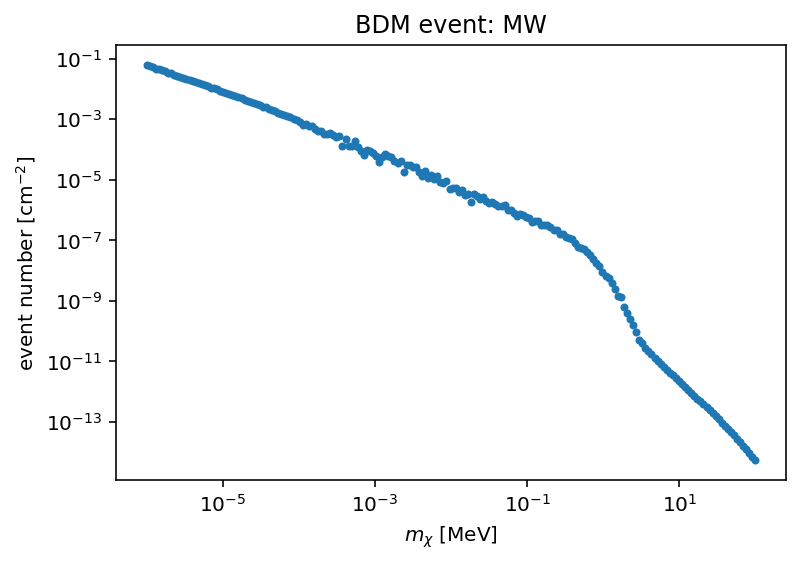

In [273]:
# plotting
plt.plot(mx_ls,bdm_event,'.')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel(r'event number ${\rm [cm^{-2}]}$')
plt.title('BDM event: '+kind)
#plt.savefig('bdm_event_number_'+kind+'.pdf',facecolor='white',bbox_inches='tight')

In [32]:
bdm_event[-1]

NameError: name 'bdm_event' is not defined

In [134]:
# for LMC case: the 1st 9 years is for Kamiokande and the last 26 years is for Super-K
# timing
start_time_int_mp = timer()

# number of cpu cores
cpu_count = mp.cpu_count()

# specified DM profile and optional setup
kind = 'LMC'
R_dist,dtype,neval = R_LMC,None,20000

# kinetic energy range to be integrated
Tx_min,Tx_max = 5,100

# how many mx should be evaluated, it is chosen to equal the available CPU cores
mx_ls = np.logspace(-6,2,200)

# initial time and maximum exposure time
#t_ini = 10

# for kamioka, starting from 10s and lasted for 9 years
def bdm_int_Kamioka(mx):
    mx_bdm_int = []
    #for Tx in Tx_ls:
    theta_m,theta_M=find_theta_bound(10,Tx_max,mx,R=R_dist)
    t_max = find_tmax(Tx_min,mx,R=R_dist)
    # restrict t_max below maximum exposure time
    if t_max > 9*yr:
        t_max = 9*yr
    else:
        pass
    theta_integ = vegas.Integrator([[10,t_max],[theta_m,theta_M],[Tx_min,Tx_max]])
    int_result = theta_integ(lambda x: bdmflux(x[0],x[1],x[2],mx,R=R_dist,kind=kind,dtype=dtype), nitn=10, neval=neval)
    return int_result.mean

# for SK, starting from 9 years and lasted for 26 years
def bdm_int_SK(mx):
    mx_bdm_int = []
    #for Tx in Tx_ls:
    theta_m,theta_M=find_theta_bound(9*yr,Tx_max,mx,R=R_dist)
    t_max = find_tmax(Tx_min,mx,R=R_dist)
    # restrict t_max below maximum exposure time
    if t_max < 9*yr:
        # all BDM flux came before the first 9 year, which is particular for very light DM
        return 0
    elif 9*yr <= t_max <= 35*yr:
        # BDM flux is non-zero between 9 and 35 years
        theta_integ = vegas.Integrator([[9*yr,t_max],[theta_m,theta_M],[Tx_min,Tx_max]])
        int_result = theta_integ(lambda x: bdmflux(x[0],x[1],x[2],mx,R=R_dist,kind=kind,dtype=dtype), nitn=10, neval=neval)
        return int_result.mean
    elif t_max > 35*yr:
        theta_integ = vegas.Integrator([[9*yr,35*yr],[theta_m,theta_M],[Tx_min,Tx_max]])
        int_result = theta_integ(lambda x: bdmflux(x[0],x[1],x[2],mx,R=R_dist,kind=kind,dtype=dtype), nitn=10, neval=neval)
        return int_result.mean

pool = mp.Pool(processes=cpu_count)
bdm_event_Kamioka = pool.map(bdm_int_Kamioka, mx_ls)

pool = mp.Pool(processes=cpu_count)
bdm_event_SK = pool.map(bdm_int_SK, mx_ls)

end_time_int_mp = timer()

show_timing(start_time_int_mp,end_time_int_mp)
#print('Total ' + f"{end_time_int_mp-start_time_int_mp:.3f}" + ' seconds for ' + str(len(mx_ls)) + ' DM masses', end='\r')

In [271]:
np.savetxt('./BDM_data/event_number/combined/event_vs_mx.txt',np.asarray([mx_ls,bdm_event_Kamioka,bdm_event_SK]).T,fmt='%.5e')

Text(0.5, 1.0, 'LMC: $\\sigma_{\\chi\\nu,e}=10^{-35}\\,{\\rm cm^{2}}$')

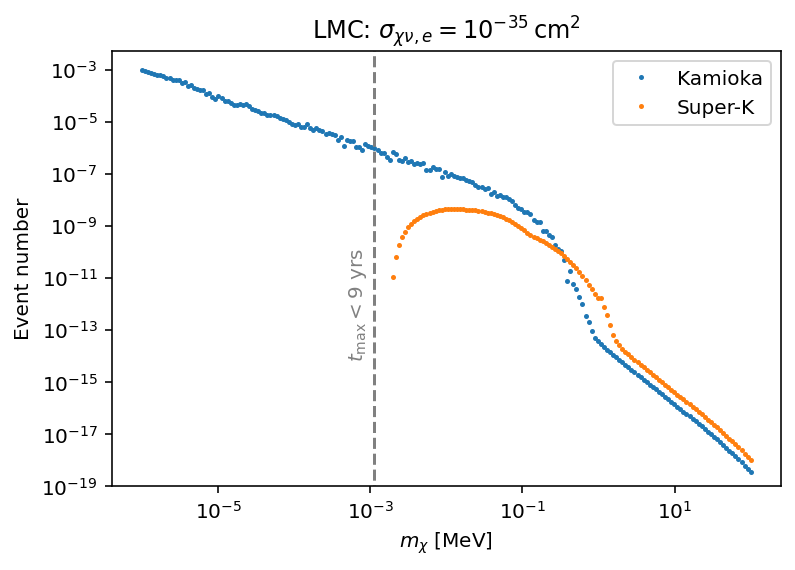

In [274]:
# Detector form factor

# plotting
plt.plot(mx_ls,bdm_event_Kamioka,'.',markersize=3,label='Kamioka')
plt.plot(mx_ls,bdm_event_SK,'.',markersize=3,label='Super-K')
plt.plot([0.001104046,0.001104046],[1e-20,1e-2],'--',color='grey')
plt.text(5e-4, 1e-14,r'$t_{\rm max}<9$ yrs',rotation=90, color = 'gray')
plt.ylim(1e-19,5e-3)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel('Event number')
#plt.title('BDM event: '+kind)
plt.title(r'LMC: $\sigma_{\chi\nu,e}=10^{-35}\,{\rm cm^{2}}$')
#plt.savefig('bdm_event_number_LMC_Kamioka_SK.pdf',facecolor='white',bbox_inches='tight')

In [261]:
root_scalar(lambda mx:find_tmax(30,mx,R=R_LMC)/yr - 9,method='brentq',bracket=[1e-5,1e-1])

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 0.0066242761820179095

## Comparision: MW and LMC

Previous saved results are loaded here to compare between MW and LMC.

### BDM flux

In [7]:
# BDM flux
MW_flux_1eV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_1e-06.txt')
MW_flux_10eV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_1e-05.txt')
MW_flux_100eV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_0.0001.txt')
MW_flux_1keV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_0.001.txt')
MW_flux_10keV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_0.01.txt')
MW_flux_100keV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_0.1.txt')
MW_flux_1MeV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_1.txt')
MW_flux_10MeV = np.loadtxt('./BDM_data/flux/MW/bdm_flux_Tx_10_mx_10.txt')
LMC_flux_1eV = np.loadtxt('./BDM_data/flux/LMC/bdm_flux_Tx_10_mx_1e-06.txt')
LMC_flux_1keV = np.loadtxt('./BDM_data/flux/LMC/bdm_flux_Tx_10_mx_0.001.txt')
LMC_flux_1MeV = np.loadtxt('./BDM_data/flux/LMC/bdm_flux_Tx_10_mx_1.txt')

Text(0.5, 1.0, '$T_\\chi=10~{\\rm MeV~and~}\\sigma_{\\chi\\nu}=10^{-35}~{\\rm cm^{-2}}$')

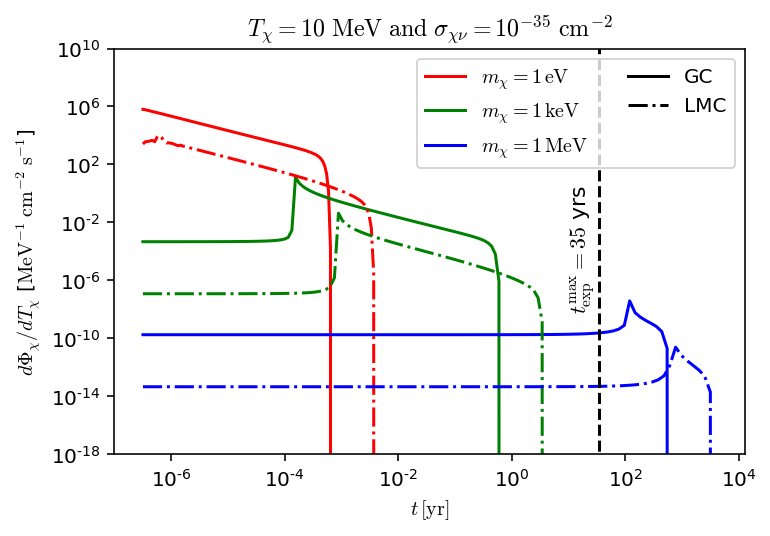

In [8]:
# plotting
plt.figure(figsize=(5*1.13,3.3*1.13))
plt.plot(MW_flux_1eV.T[0]/yr,1e10*2*np.pi*MW_flux_1eV.T[1],'r',label=r'$m_\chi=1\,{\rm eV}$')
plt.plot(MW_flux_1keV.T[0]/yr,1e10*2*np.pi*MW_flux_1keV.T[1],'g',label=r'$m_\chi=1\,{\rm keV}$')
plt.plot(MW_flux_1MeV.T[0]/yr,1e10*2*np.pi*MW_flux_1MeV.T[1],'b',label=r'$m_\chi=1\,{\rm MeV}$')
plt.plot(LMC_flux_1eV.T[0]/yr,1e10*2*np.pi*LMC_flux_1eV.T[1],'r-.')
plt.plot(LMC_flux_1keV.T[0]/yr,1e10*2*np.pi*LMC_flux_1keV.T[1],'g-.')
plt.plot(LMC_flux_1MeV.T[0]/yr,1e10*2*np.pi*LMC_flux_1MeV.T[1],'b-.')
plt.plot([1e-6,1e-4],[1e-30,1e-30],'k-',label='GC')
plt.plot([1e-6,1e-4],[1e-30,1e-30],'k-.',label='LMC')
plt.plot([35,35],[1e-20,1e12],'--',color='black')
plt.text(10, 3e-8,r'$t_{\rm exp}^{\rm max}=35$ yrs',rotation=90, color = 'black',fontsize=11)
plt.legend(ncol=2,fontsize=10)
plt.ylim(1e-18,1e10)
plt.xlabel(r'$t\,{\rm [yr]}$')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [${\rm MeV^{-1}~cm^{-2}~s^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$T_\chi=10~{\rm MeV~and~}\sigma_{\chi\nu}=10^{-35}~{\rm cm^{-2}}$')
#plt.savefig('diff_BDM_flux.pdf',facecolor='white',bbox_inches='tight')

Text(0.5, 1.0, '$T_\\chi=10~{\\rm MeV~and~}\\sigma_{\\chi\\nu}=10^{-35}~{\\rm cm^{-2}}$')

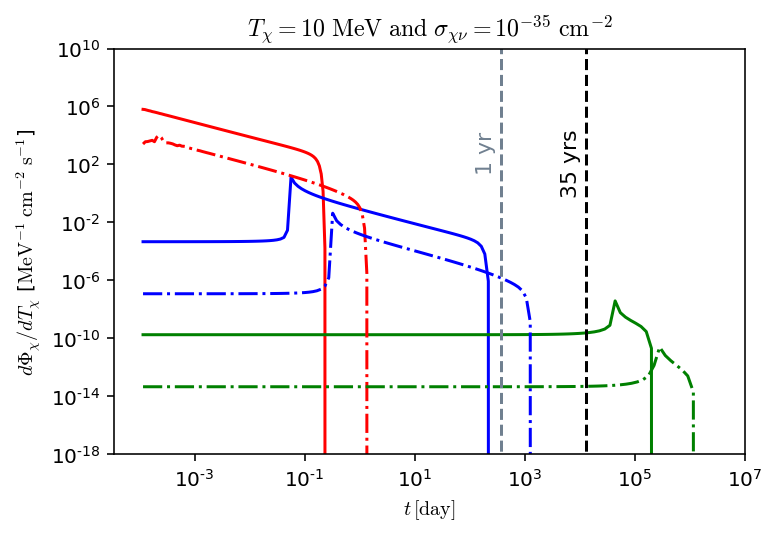

In [9]:
plt.figure(figsize=(5*1.13,3.3*1.13))
plt.plot(MW_flux_1eV.T[0]/86400,1e10*2*np.pi*MW_flux_1eV.T[1],'r',label=r'$m_\chi=1\,{\rm eV}$')
plt.plot(MW_flux_1keV.T[0]/86400,1e10*2*np.pi*MW_flux_1keV.T[1],'b',label=r'$m_\chi=1\,{\rm MeV}$')
plt.plot(MW_flux_1MeV.T[0]/86400,1e10*2*np.pi*MW_flux_1MeV.T[1],'g',label=r'$m_\chi=1\,{\rm keV}$')
plt.plot(LMC_flux_1eV.T[0]/86400,1e10*2*np.pi*LMC_flux_1eV.T[1],'r-.')
plt.plot(LMC_flux_1keV.T[0]/86400,1e10*2*np.pi*LMC_flux_1keV.T[1],'b-.')
plt.plot(LMC_flux_1MeV.T[0]/86400,1e10*2*np.pi*LMC_flux_1MeV.T[1],'g-.')
#plt.plot([1e-6,1e-4],[1e-30,1e-30],'k-',label='GC')
#plt.plot([1e-6,1e-4],[1e-30,1e-30],'k-.',label='LMC')
plt.plot([35*365,35*365],[1e-20,1e12],'--',color='black')
plt.text(12.5*365, 1,'35 yrs',rotation=90, color = 'black',fontsize=11)
plt.plot([365,365],[1e-20,1e12],'--',color='slategrey')
plt.text(0.35*365, 40,'1 yr',rotation=90, color = 'slategrey',fontsize=11)
#plt.legend(ncol=2,fontsize=10)
plt.xlim(3/86400,1e7)
plt.ylim(1e-18,1e10)
plt.xlabel(r'$t\,{\rm [day]}$')
plt.ylabel(r'$d\Phi_\chi/dT_\chi$ [${\rm MeV^{-1}~cm^{-2}~s^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$T_\chi=10~{\rm MeV~and~}\sigma_{\chi\nu}=10^{-35}~{\rm cm^{-2}}$')
#plt.savefig('ppp14/all_flux.pdf',facecolor='white',bbox_inches='tight')

In [90]:
1e10*2*np.pi*MW_flux_1keV.T[1]

array([4.52981218e-04, 4.53018289e-04, 4.53064785e-04, 4.53117563e-04,
       4.53179139e-04, 4.53249510e-04, 4.53336218e-04, 4.53437377e-04,
       4.53549846e-04, 4.53679908e-04, 4.53835103e-04, 4.54016059e-04,
       4.54217749e-04, 4.54464678e-04, 4.54743652e-04, 4.55073519e-04,
       4.55452395e-04, 4.55895988e-04, 4.56414351e-04, 4.57017536e-04,
       4.57728165e-04, 4.58560687e-04, 4.59537722e-04, 4.60683775e-04,
       4.62039686e-04, 4.63644412e-04, 4.65557642e-04, 4.67834040e-04,
       4.70571624e-04, 4.73879721e-04, 4.77915411e-04, 4.82877242e-04,
       4.89075604e-04, 4.96930214e-04, 5.07107090e-04, 5.20664319e-04,
       5.39449158e-04, 5.66995899e-04, 6.11057364e-04, 6.92953658e-04,
       9.01555410e-04, 2.81011693e-03, 1.29267741e+01, 5.13400956e+00,
       3.02355673e+00, 2.05041699e+00, 1.49329952e+00, 1.13572973e+00,
       8.89164969e-01, 7.10414630e-01, 5.76254801e-01, 4.72785190e-01,
       3.91371445e-01, 3.26297751e-01, 2.73589994e-01, 2.30465352e-01,
      

In [102]:
1e10*2*np.pi*MW_flux_1MeV.T[1]

array([1.71116269e-10, 1.71115012e-10, 1.71115640e-10, 1.71116897e-10,
       1.71115640e-10, 1.71116269e-10, 1.71116269e-10, 1.71116897e-10,
       1.71116269e-10, 1.71116269e-10, 1.71116269e-10, 1.71116269e-10,
       1.71116269e-10, 1.71116269e-10, 1.71115012e-10, 1.71116269e-10,
       1.71116269e-10, 1.71115012e-10, 1.71116269e-10, 1.71116269e-10,
       1.71116269e-10, 1.71115012e-10, 1.71116269e-10, 1.71116269e-10,
       1.71116269e-10, 1.71116269e-10, 1.71116269e-10, 1.71116269e-10,
       1.71115012e-10, 1.71115012e-10, 1.71115640e-10, 1.71115640e-10,
       1.71115640e-10, 1.71115640e-10, 1.71115640e-10, 1.71115640e-10,
       1.71116269e-10, 1.71116269e-10, 1.71116269e-10, 1.71116897e-10,
       1.71117525e-10, 1.71118782e-10, 1.71119410e-10, 1.71120039e-10,
       1.71121295e-10, 1.71122552e-10, 1.71124437e-10, 1.71126322e-10,
       1.71128835e-10, 1.71131977e-10, 1.71135747e-10, 1.71140145e-10,
       1.71145800e-10, 1.71152711e-10, 1.71160879e-10, 1.71172817e-10,
      

In [117]:
MW_flux_1MeV.T[1,2]/LMC_flux_1MeV.T[1,2]

3926.1674819181403

### BDM event

Corrected with detector form factor and $\sigma_{\chi e}=\sigma_{\chi \nu}=10^{-35}\,{\rm cm^2}$.

In [10]:
# BDM event
# load data
MW_event = np.loadtxt('./BDM_data/event_number/MW/event_vs_mx.txt')
LMC_event = np.loadtxt('./BDM_data/event_number/combined/event_vs_mx.txt')

In [11]:
# total electron number
Ne_SK = 7.473e33
Ne_Kamioka = Ne_SK*(2.14/22.5)
# correction on sigma_xv
sigxv = 1e-35
corr_sigxv = sigxv/1e-45
# sigma_xe cross section
sigxe = sigxv
# detector form factor
Kamioka_ff = Ne_Kamioka*corr_sigxv*sigxe 
SK_ff = Ne_SK*corr_sigxv*sigxe
# Event number correction
LMC_event_Kamioka = np.asarray(LMC_event.T[1])*Kamioka_ff
LMC_event_SK = np.asarray(LMC_event.T[2])*SK_ff
LMC_event_combined = LMC_event_Kamioka+LMC_event_SK
MW_event_SK = MW_event.T[1]*SK_ff
MW_event_HK = MW_event.T[1]*SK_ff*10

In [12]:
# SK observed
# total event -1<z<1 in (5-100) MeV, per kton per year
SK_obs = 526.314
# SK fiducial mass, kton
SK_mass = 22.5
# dealing t_exp for mx
SK_texp_ls = []
Kamioka_texp_ls = []
mx_ls = np.logspace(-6,2,200)
for mx in mx_ls:
    SK_texp = find_tmax(5,mx,th=1e-10,max_a=0.5*np.pi,R=R_MW)/yr
    if SK_texp <= 35:
        SK_texp_ls.append(SK_texp)
    else:
        SK_texp_ls.append(35)
    
    Kamioka_texp = find_tmax(5,mx,th=1e-10,max_a=0.5*np.pi,R=R_LMC)/yr    
    if Kamioka_texp <= 9:
        Kamioka_texp_ls.append(Kamioka_texp)
    else:
        Kamioka_texp_ls.append(9)
SK_texp_ls = np.asarray(SK_texp_ls)
Kamioka_texp_ls = np.asarray(Kamioka_texp_ls)
# dealing with the associated bkg for mx in SK
SK_bkg = SK_texp_ls*SK_obs*SK_mass
Kamioka_bkg = Kamioka_texp_ls*SK_obs*SK_mass/10

Text(0.5, 1.0, '$\\sigma_{\\chi\\nu}=\\sigma_{\\chi e}=10^{-35}\\,{\\rm cm^{2}}$')

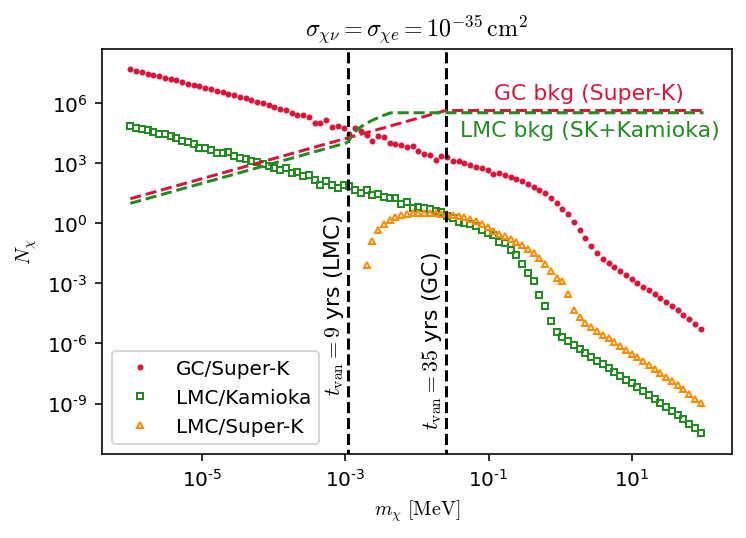

In [15]:
# plotting
# event
plt.figure(figsize=(5*1.13,3.3*1.13))
plt.plot(MW_event.T[0][::2],MW_event_SK[::2],'.',color='crimson',markersize=4,label='GC/Super-K')
#plt.plot(LMC_event.T[0],LMC_event_combined,'.',color='firebrick',label='LMC/combined')
plt.plot(LMC_event.T[0][::2],LMC_event_Kamioka[::2],'s',markersize=3,color='forestgreen',fillstyle='none',label='LMC/Kamioka')
plt.plot(LMC_event.T[0][::2],LMC_event_SK[::2],'^',color='darkorange',fillstyle='none',markersize=3,label='LMC/Super-K')
plt.plot([0.001104046,0.001104046],[1e-15,1e10],'--',color='black')
plt.text(4.8e-4, 5e-9,r'$t_{\rm van}=9$ yrs (LMC)',rotation=90, color = 'black',fontsize=11)
plt.plot([0.0252712,0.0252712],[1e-15,1e10],'--',color='black')
plt.text(1.1e-2, 1e-10,r'$t_{\rm van}=35$ yrs (GC)',rotation=90, color = 'black',fontsize=11)
# bkg
plt.plot(mx_ls,SK_bkg,'--',color='crimson')
plt.plot(mx_ls,combined_bkg,'--',color='forestgreen')
#plt.plot(mx_ls,Kamioka_bkg,'--',color='forestgreen')
#plt.plot(mx_ls,LMC_SK_bkg,'--',color='forestgreen')
plt.text(0.12, 1.4e6,'GC bkg (Super-K)', color = 'crimson',fontsize=11)
plt.text(0.04, 2e4,'LMC bkg (SK+Kamioka)', color = 'forestgreen',fontsize=11)
plt.ylim(3e-12,5e8)
#plt.xlim(5e-7,100)
plt.legend(fontsize=10)
plt.xlabel(r'$m_\chi~{\rm [MeV]}$')
plt.ylabel(r'$N_\chi$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$\sigma_{\chi\nu}=\sigma_{\chi e}=10^{-35}\,{\rm cm^{2}}$')
#plt.savefig('int_BDM_event.pdf',facecolor='white',bbox_inches='tight')

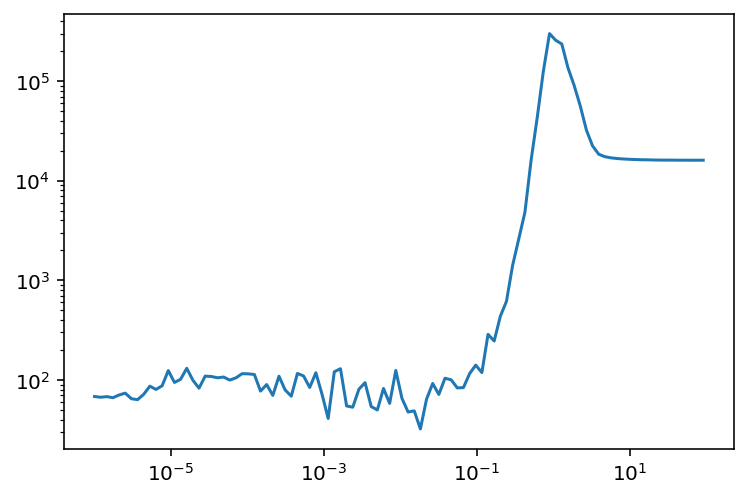

In [529]:
#mx_ls=np.logspace(-6,2,200)
plt.plot(mx_ls[::2],MW_event_SK[::2]/LMC_event_Kamioka[::2]/10)
plt.xscale('log')
plt.yscale('log')

In [536]:
np.sum(MW_event_SK[:50]/LMC_event_Kamioka[:50]/10)/50

92.07795027373457

In [535]:
root_scalar(lambda n: (50/8.5)**n-92,method='brentq',bracket=[1,10])

      converged: True
           flag: 'converged'
 function_calls: 15
     iterations: 14
           root: 2.551861574754361

In [14]:
# sensitivity, the cross sections for both nu and e are 1e-35
LMC_tot_event = LMC_event_Kamioka+LMC_event_SK
tot_points = len(MW_event_SK)
mx_ls = np.logspace(-6,2,200)
# dealing with the SK bkg for combined SK+Kamioka
SK_texp_combined = []
for mx in mx_ls:
    SK_texp = find_tmax(5,mx,th=1e-10,max_a=0.5*np.pi,R=R_LMC)/yr
    if 9 <= SK_texp <= 35:
        SK_texp_combined.append(SK_texp-9)
    elif SK_texp > 35:
        SK_texp_combined.append(35-9) 
    else:
        SK_texp_combined.append(0)
SK_texp_combined = np.asarray(SK_texp_combined)
# dealing with the associated bkg for combined
LMC_SK_bkg = SK_texp_combined*SK_obs*SK_mass
combined_bkg = SK_texp_combined*SK_obs*SK_mass + Kamioka_bkg

In [16]:
# load existing constraints
cr = np.loadtxt('./constraints/ema_superK.txt')
xe1t = np.loadtxt('./constraints/direct_search.txt')
solar_reflect = np.loadtxt('./constraints/solar_reflection.txt')
cr = 10**cr
xe1t = 10**xe1t
solar_reflect = 10**solar_reflect

In [19]:
MW_sensitivity = []
MW_sensitivity_HK = []
LMC_sensitivity = []
for i in range(0,tot_points):
    sens_MW = root_scalar(lambda f: f**2*MW_event_SK[i]/np.sqrt(f**2*MW_event_SK[i]+SK_bkg[i])-2,method='brentq',bracket=[1e-10,1e10]).root
    sens_MW_HK = root_scalar(lambda f: f**2*MW_event_HK[i]/np.sqrt(f**2*MW_event_HK[i]+10*SK_bkg[i])-2,method='brentq',bracket=[1e-10,1e10]).root
    sens_LMC = root_scalar(lambda f: f**2*LMC_tot_event[i]/np.sqrt(f**2*LMC_tot_event[i]+combined_bkg[i])-1.645,method='brentq',bracket=[1e-10,1e10]).root
    MW_sensitivity.append(sens_MW*1e-35)
    MW_sensitivity_HK.append(sens_MW_HK*1e-35)
    LMC_sensitivity.append(sens_LMC*1e-35)
MW_sensitivity = np.asarray(MW_sensitivity)
MW_sensitivity_HK = np.asarray(MW_sensitivity_HK)
LMC_sensitivity = np.asarray(LMC_sensitivity)

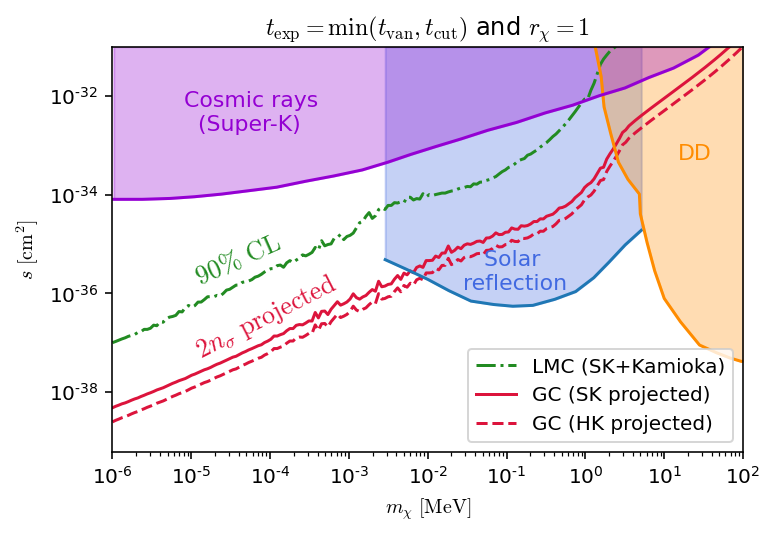

In [26]:
plt.figure(figsize=(5*1.13,3.3*1.13))
plt.plot(mx_ls,LMC_sensitivity,'-.',color='forestgreen',label='LMC (SK+Kamioka)')
plt.text(1e-5, 1.5e-36,r'$90\%~{\rm CL}$',rotation=24, color = 'forestgreen',fontsize=13)
plt.plot(mx_ls,MW_sensitivity,color='crimson',label='GC (SK projected)')
plt.plot(mx_ls,MW_sensitivity_HK,'--',color='crimson',label='GC (HK projected)')
plt.text(1e-5, 4.8e-38,r'$2n_\sigma~{\rm projected}$',rotation=27, color = 'crimson',fontsize=13)
# constraint: solar reflection
plt.plot(solar_reflect.T[0],solar_reflect.T[1])
plt.fill_between(solar_reflect.T[0], solar_reflect.T[1],1e-31,alpha=0.3,color='royalblue')
plt.text(2.8e-2, 1.2e-36,'   Solar\nreflection', color = 'royalblue',fontsize=11)
# constraint: xenon1T
plt.plot(xe1t.T[0],xe1t.T[1],color = 'darkorange')
plt.fill_between(xe1t.T[0], xe1t.T[1],1e-31,alpha=0.3, color='darkorange')
plt.text(15, 5e-34,'DD', color = 'darkorange',fontsize=11)
# constraint: cosmic ray
plt.plot(cr.T[0],cr.T[1],color='darkviolet')
plt.fill_between(cr.T[0], cr.T[1],1e-31,alpha=0.3, color='darkviolet')
plt.text(8e-6, 2e-33,'Cosmic rays\n  (Super-K)', color = 'darkviolet',fontsize=11)
plt.legend(loc='lower right',fontsize=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6,100)
plt.ylim(6e-40,1e-31)
plt.xlabel(r'$m_\chi~{\rm [MeV]}$')
plt.ylabel(r'$s~{\rm [cm^2]}$')
plt.title(r'$t_{\rm exp}={\rm min}(t_{\rm van},t_{\rm cut})$ and $r_\chi=1$')
plt.savefig('./plots/sensitivity_w_HK.pdf',facecolor='white',bbox_inches='tight')

In [23]:
np.savetxt('./constraints/ours/MW_HK.txt',np.vstack((mx_ls,MW_sensitivity_HK)).T,fmt='%.5e')

In [713]:
np.log10(mx_ls[50]/mx_ls[5])

1.809045226130653

In [714]:
np.sqrt(10)

3.1622776601683795

## BELOW ARE OBSOLETE!

In [177]:
mx = 1e-2
Tx = 10
slice_num= 10
time_ls = np.logspace(0,np.log10(find_tmax(Tx,mx)),100)

bdm_ls_new_q = []
#bdm_ls_old = []
#bdm_ls_quad_128 = []
for t in time_ls:
    # slicing the bound into multiple equal parts
    theta_ls = theta_slice(find_theta_bound(t,Tx,mx),slice_num=slice_num)
    int_val_new = 0
    #int_val_old = 0
    for i in range(slice_num-1):
        int_val_new += quad(lambda theta: bdmflux(t,theta,Tx,mx),theta_ls[i],theta_ls[i+1])[0]
        #int_val_old += quad(lambda theta: bdmflux(t,theta,Tx,mx,legacy=True),theta_ls[i],theta_ls[i+1])[0]
    bdm_ls_new_q.append(int_val_new)
    #bdm_ls_old.append(int_val_old)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars


Text(0.5, 1.0, '$T_\\chi=10\\,{\\rm MeV},\\,m_\\chi=1\\,{\\rm eV}$')

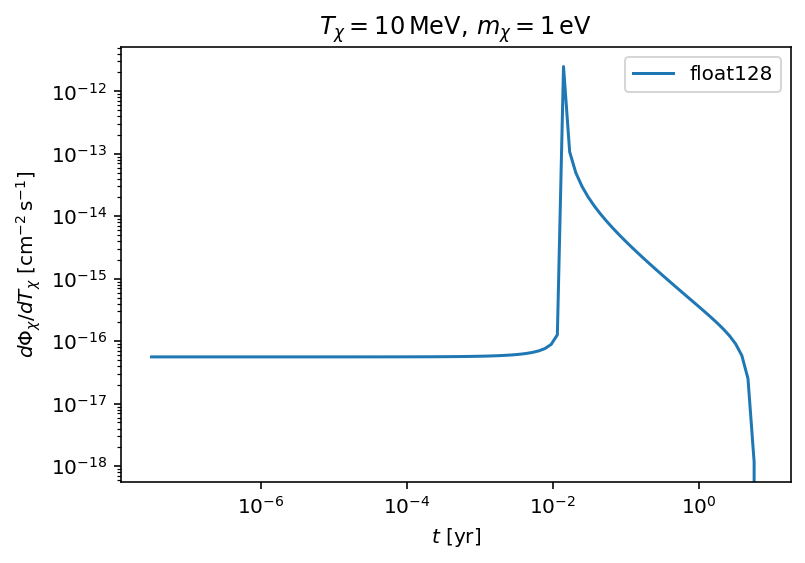

In [171]:
#plt.plot(time_ls/yr,bdm_ls_old,label='float64')
plt.plot(time_ls/yr,bdm_ls_new,label='float128')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-9,)
plt.xlabel('$t$ [yr]')
plt.ylabel(r'$d\Phi_\chi/dT_\chi~[{\rm cm^{-2}\,s^{-1}}]$')
plt.legend()
plt.title(r'$T_\chi=10\,{\rm MeV},\,m_\chi=1\,{\rm eV}$')
#plt.savefig('test_bdm_dtype.pdf',facecolor='white')

In [972]:
t,Tx,mx=0.1*yr,10,0.01
theta_m,theta_M = find_theta_bound(t,Tx,mx,R=50)
theta_ls = np.logspace(np.log10(theta_m),np.log10(theta_M),200)
bdm_vs_th = []
#bdm_vs_th_exact = []
for th in theta_ls:
    bdm_vs_th.append(bdmflux(t,th,Tx,mx,r_cut=1e-5,R=50))

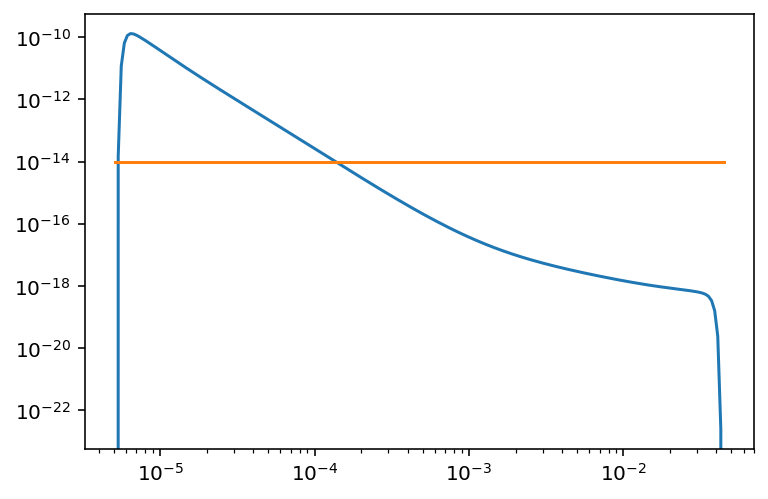

In [973]:
plt.plot(theta_ls,bdm_vs_th)
plt.plot([theta_m,theta_M],[1e-14,1e-14])
#plt.ylim(1e-20,1e-9)
plt.xscale('log')
plt.yscale('log')

In [982]:
Tx,mx,t=10,1e-3,1e-3*yr
r_ls,l_ls,a_ls,cos_ls,a_leg_ls=[],[],[],[],[]
vdm = vx(Tx,mx)
theta_m,theta_M = find_theta_bound(t,Tx,mx)
theta_ls = np.logspace(np.log10(theta_m),np.log10(theta_M),200)
for th in theta_ls:
    l,r,a,_=find_lra(t,th,vdm)
    _,_,a_leg,_=find_lra(t,th,vdm,legacy=True)
    l_ls.append(l)
    r_ls.append(r)
    a_ls.append(a)
    a_leg_ls.append(a_leg)
    cos_ls.append(np.cos(th))
    #r2_ls.append(r2)

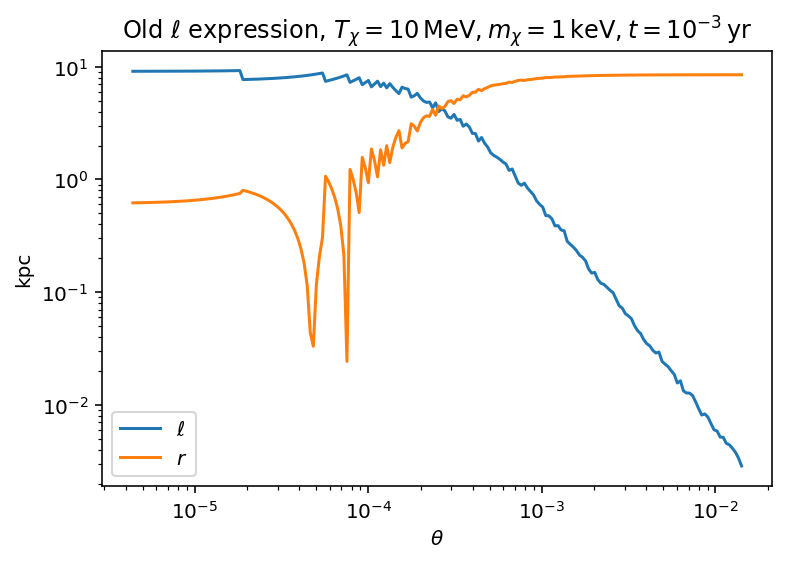

In [981]:
plt.plot(theta_ls,np.asarray(l_ls)/kpc2cm,label='$\ell$')
plt.plot(theta_ls,np.asarray(r_ls)/kpc2cm,label='$r$')
plt.legend()
#plt.plot(theta_ls,np.asarray(l_ls)/kpc2cm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel('kpc')
plt.title(r'Old $\ell$ expression, $T_\chi=10\,{\rm MeV},m_\chi=1\,{\rm keV},t=10^{-3}\,{\rm yr}$')
plt.savefig('Old_l_expression.pdf',facecolor='white')

Text(0, 0.5, 'cm')

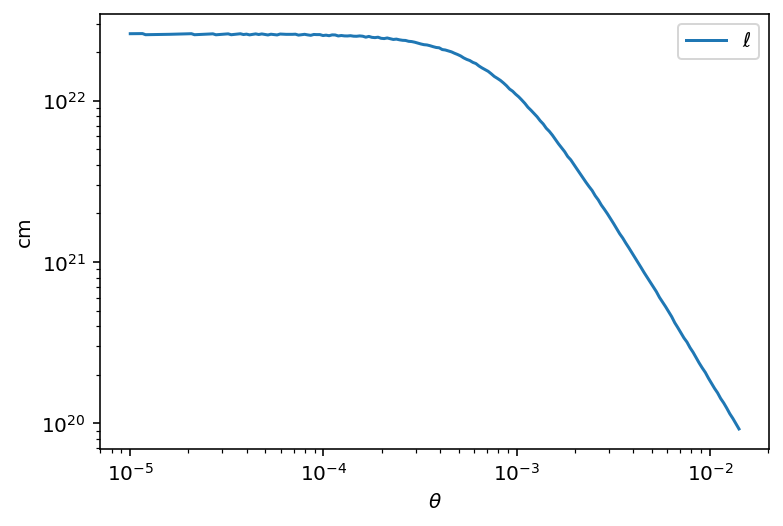

In [662]:
plt.plot(theta_ls,np.asarray(l_ls),label='$\ell$')
#plt.plot(theta_ls,np.asarray(r_ls),label='$r$')
plt.legend()
#plt.plot(theta_ls,np.asarray(l_ls)/kpc2cm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel('cm')
#plt.ylim(1e22,3e22)

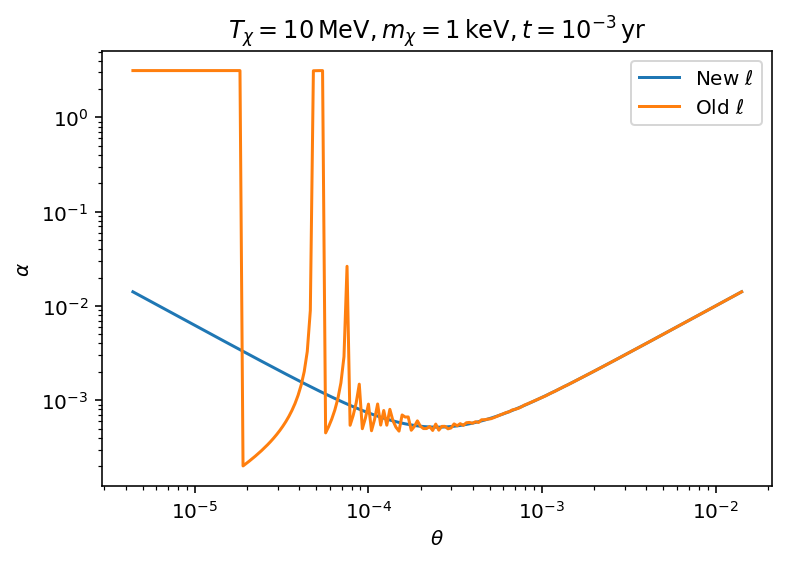

In [989]:
plt.plot(theta_ls,a_ls,label='New $\ell$')
plt.plot(theta_ls,a_leg_ls,label='Old $\ell$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\alpha$')
plt.legend()
plt.title(r'$T_\chi=10\,{\rm MeV},m_\chi=1\,{\rm keV},t=10^{-3}\,{\rm yr}$')
plt.savefig('alpha.pdf',facecolor='white')

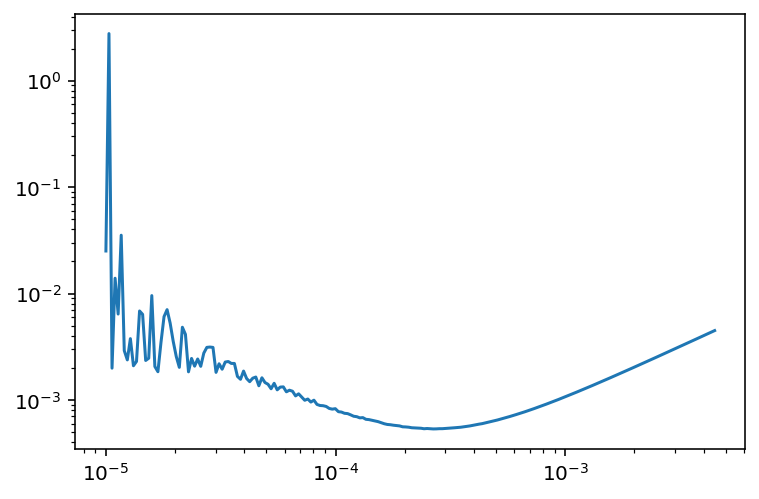

In [588]:
plt.plot(theta_ls,a_ls)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-2,3)

In [346]:
np.cos(theta_m)

0.9999995705961299

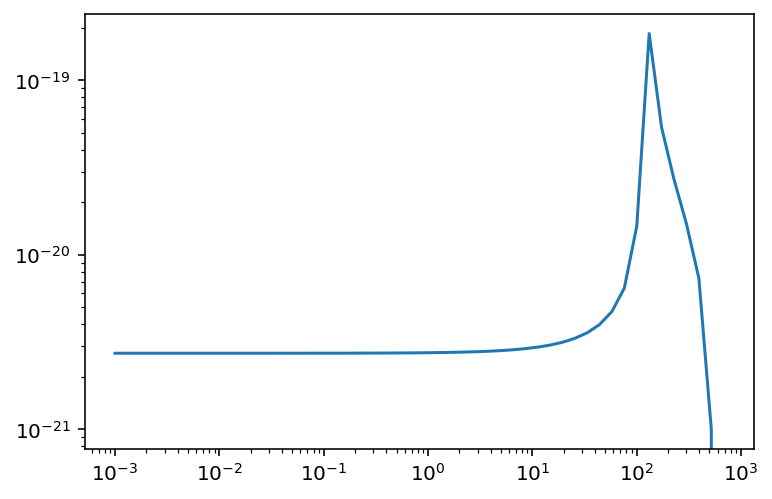

In [186]:
plt.plot(time_ls/yr,bdm_ls)
plt.xscale('log')
plt.yscale('log')

In [28]:
Tx_ls = np.linspace(5,100,30)
#bdm_int = []
mx_ls = np.logspace(-6,0,20)
#for mx in mx_ls:
def bdm_int(mx):
    mx_bdm_int = []
    #for Tx in Tx_ls:
    theta_m,theta_M=find_theta_bound(1,5,mx)
    theta_integ = vegas.Integrator([[1,find_tmax(5,mx)],[theta_m,theta_M],[5,100]])
    int_result = theta_integ(lambda x: bdmflux(x[0],x[1],x[2],mx), nitn=10, neval=5000)
    return int_result.mean
    #mx_bdm_int.append(int_result.mean)
    #bdm_int.append(mx_bdm_int)

In [30]:
start_mp = timer()
pool = mp.Pool(processes=64)
bdm_int_result = pool.map(bdm_int, mx_ls)
end_mp = timer()
print(end_mp-start_mp)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_sc

9.934335054829717


In [32]:
start = timer()
bdm_int_result = []
for mx in mx_ls:
    bdm_int_result.append(bdm_int(mx))
end = timer()
print(end-start)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars


64.9639557376504


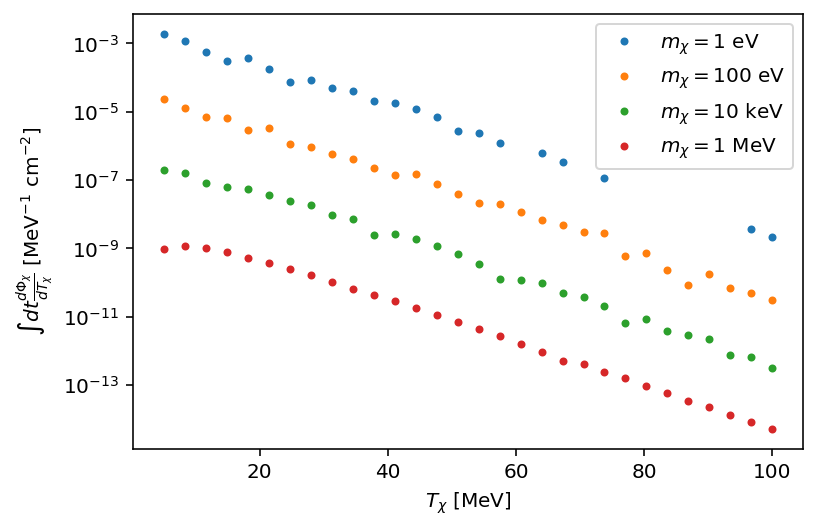

In [144]:
plt.plot(Tx_ls,bdm_int[0],'.',label='$m_\chi = 1$ eV')
plt.plot(Tx_ls,bdm_int[1],'.',label='$m_\chi = 100$ eV')
plt.plot(Tx_ls,bdm_int[2],'.',label='$m_\chi = 10$ keV')
plt.plot(Tx_ls,bdm_int[3],'.',label='$m_\chi = 1$ MeV')
#plt.plot(Tx_ls,bdm_int[4],label='$m_\chi = 100$ MeV')
plt.yscale('log')
plt.legend()
plt.xlabel('$T_\chi$ [MeV]')
plt.ylabel(r'$\int dt \frac{d\Phi_\chi}{dT_\chi}~{\rm [MeV^{-1}~cm^{-2}]}$')
#plt.savefig('bdm_event.pdf',facecolor='white',bbox_inches='tight')

Text(0, 0.5, '$\\int dtdT_\\chi~\\frac{d\\Phi_\\chi}{dT_\\chi}~{\\rm [cm^{-2}]}$')

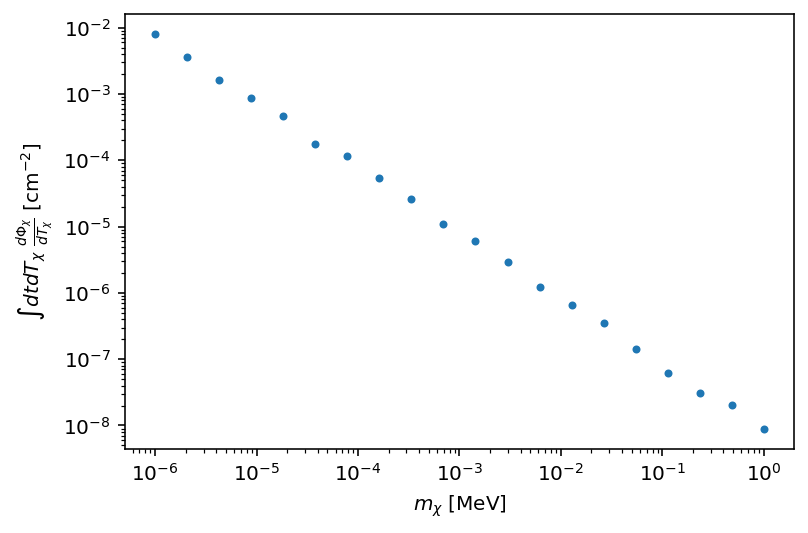

In [31]:
plt.plot(mx_ls,bdm_int_result,'.')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel(r'$\int dtdT_\chi~\frac{d\Phi_\chi}{dT_\chi}~{\rm [cm^{-2}]}$')
#plt.savefig('bdm_event_tot.pdf',facecolor='white',bbox_inches='tight')

Text(0, 0.5, '$\\int dtdT_\\chi~\\frac{d\\Phi_\\chi}{dT_\\chi}~{\\rm [cm^{-2}]}$')

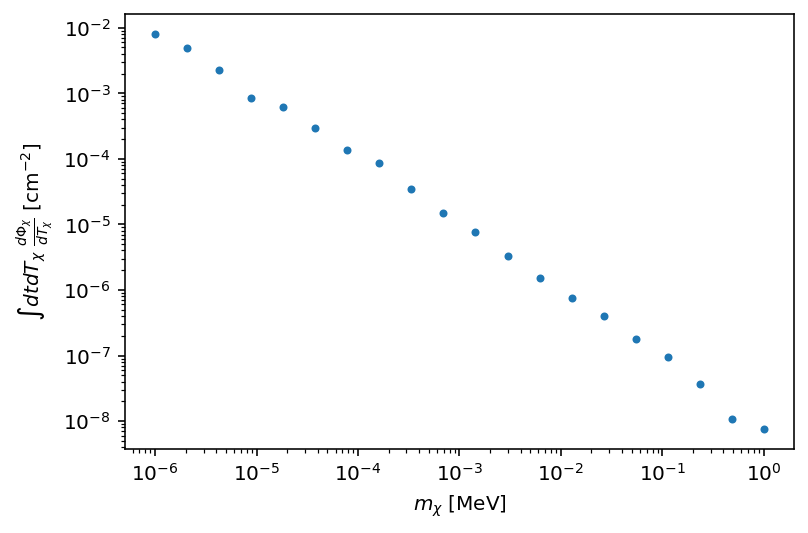

In [33]:
plt.plot(mx_ls,bdm_int_result,'.')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlabel('$m_\chi$ [MeV]')
plt.ylabel(r'$\int dtdT_\chi~\frac{d\Phi_\chi}{dT_\chi}~{\rm [cm^{-2}]}$')

In [175]:
mx = 1e-2
Tx = 10
slice_num= 10
time_ls = np.logspace(0,np.log10(find_tmax(Tx,mx)),100)

bdm_ls_new = []
#bdm_ls_old = []
#bdm_ls_quad_128 = []
for t in time_ls:
    # slicing the bound into multiple equal parts
    #theta_ls = theta_slice(find_theta_bound(t,Tx,mx),slice_num=slice_num)
    theta_m,theta_M=find_theta_bound(t,Tx,mx)
    #int_val= 0
    theta_integ = vegas.Integrator([[theta_m,theta_M]])
    int_val = theta_integ(lambda x: bdmflux(t,x[0],Tx,mx), nitn=10, neval=3000)
    #int_val_old = 0
    #for i in range(slice_num-1):
    #    theta_integ = vegas.Integrator([[theta_ls[i],theta_ls[i+1]]])
    #    int_val += theta_integ(lambda x: bdmflux(t,x[0],Tx,mx), nitn=10, neval=1000)
        #int_val_old += quad(lambda theta: bdmflux(t,theta,Tx,mx,legacy=True),theta_ls[i],theta_ls[i+1])[0]
    bdm_ls_new.append(int_val.mean)
    #bdm_ls_old.append(int_val_old)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in double_scalars


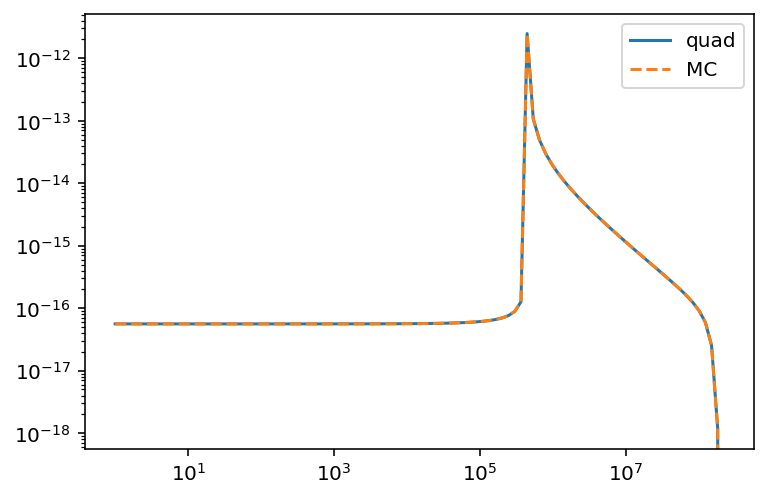

In [185]:
plt.plot(time_ls,bdm_ls_new_q,label='quad')
plt.plot(time_ls,bdm_ls_new,'--',label='MC')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [27]:
find_theta_bound(1000000,5,1e-5)

(0, 0.0019999973334060743)

Text(0, 0.5, 'arrival time [yr]')

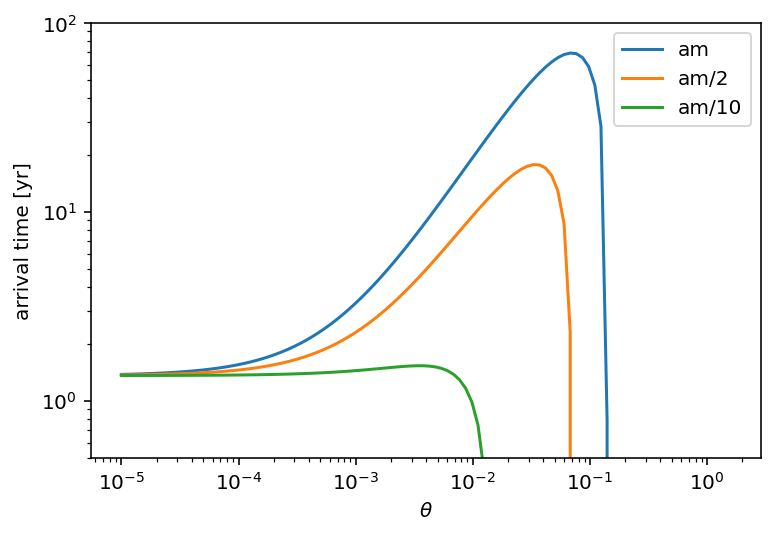

In [243]:
plt.plot(th_ls,tt_ls,label='am')
plt.plot(th_ls,tt_ls2,label='am/2')
plt.plot(th_ls,tt_ls3,label='am/10')
#plt.plot([[1e-5,0.5*np.pi]],[[8,8]],'--')
plt.xlabel(r'$\theta$')
plt.legend()
plt.xscale('log')
plt.ylim(0.5,100)
plt.yscale('log')
plt.xlabel(r'$\theta$')
plt.ylabel('arrival time [yr]')

In [10]:
find_theta_bound(10,0.1,0)

0.14048970175302428

In [16]:
tt(10,0.1,0.14048970175302,amin)

0.0001220703125

In [135]:
root_scalar(lambda th: np.cos(amin-th)/np.cos(th)-vx(10,0.1),bracket=[0, 0.5*np.pi],method='brentq')

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.06989652246922248

In [151]:
th_ls[np.argmax(tt_ls)]

0.022250241724347083

In [152]:
np.max(tt_ls)

69.26922275226967

In [156]:
8.5*kpc2cm*(1/vx(10,0.1)/c-1/c)/yr

1.3598823884477358

In [71]:
mx = 1
Tx = 10

# years
yrls=np.logspace(2,np.log10(np.floor(find_tmax(Tx,mx))),30)
#yrls = np.append(yrls1,yrls2)
theta_slice = 8
tot_job = len(yrls)
job = 1
#fluxmx1_single=[]
#for y in yrls:
#    fluxmx1_single.append(bdmflux_single(y*yr,Tx,mx1))

#fluxmx2_single=[]
#for y in yrls:
#    fluxmx2_single.append(bdmflux_single(y*yr,Tx,mx2))
    
bdmflux_vegas=[]
for y in yrls[:-1]:
    theta_min,theta_max = find_theta_bound(y,Tx,mx)
    D = (theta_max-theta_min)/10**theta_slice
    #bdmflux = 0
    theta_integ = vegas.Integrator([[theta_min, theta_min+10*D]])
    flux = theta_integ(lambda theta: bdmflux(y,theta,Tx,mx), nitn=10, neval=3000)
    try:
        bdm = flux[0].mean
    except:
        bdm = flux.mean
    
    for i in range(1,theta_slice):
        theta_integ = vegas.Integrator([[theta_min+10**i*D, theta_min+10**(i+1)*D]])
        flux = theta_integ(lambda theta: bdmflux(y,theta,Tx,mx), nitn=10, neval=3000)
        try:
            bdm += flux[0].mean
        except:
            bdm += flux.mean
    bdmflux_vegas.append(bdm)
    print('Current BDM is '+str(bdm)+' and total '+str(job)+' out of '+str(tot_job)+' jobs are complete!',end="\r")
    job+=1
    

#fluxmx4_single=[]
#for y in yrls:
#    fluxmx4_single.append(bdmflux_single(y*yr,Tx,mx4))


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:140: RuntimeWarning: divide by zero encountered in true_divide


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


ValueError: array must not contain infs or NaNs

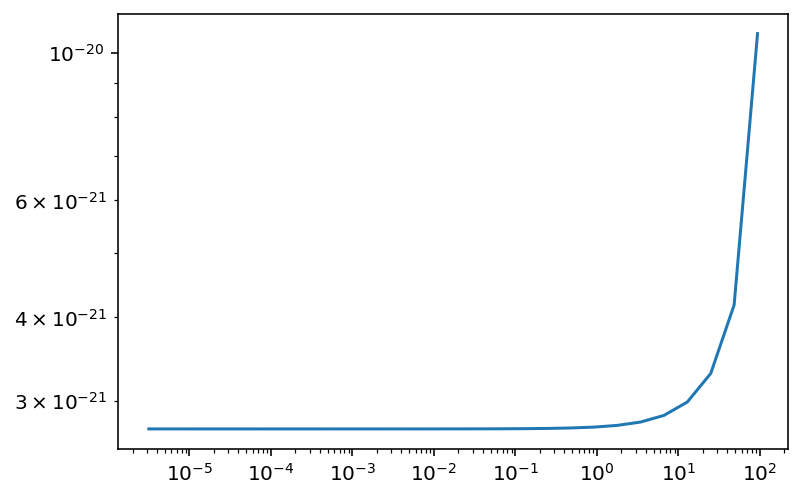

In [73]:
plt.plot(yrls[:-3]/yr,bdmflux_vegas)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-17,1e-12)

In [46]:
bdmflux_vegas

[<function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, sigxv=1e-45, rho=184, rs=24.42, Lv=5e+51, R=8.5, r_cut=1e-05)>,
 <function __main__.bdmflux(t, theta, Tx, mx, tau=10, si

In [28]:
find_theta_bound(0.1*yr,Tx,mx)

(0.0005288940774503469, 0.013611591850174597)

In [33]:
flux=5

In [35]:
flux+=1

In [36]:
flux

6

In [127]:
theta_integ(lambda x: bdmflux(yrls[3],x[0],x[1],mx3), nitn=20, neval=10000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


1.718(14)e-21

In [128]:
theta_integ(lambda x: bdmflux(yrls[3],x[0],x[1],mx3), nitn=20, neval=10000)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


1.7190(10)e-21

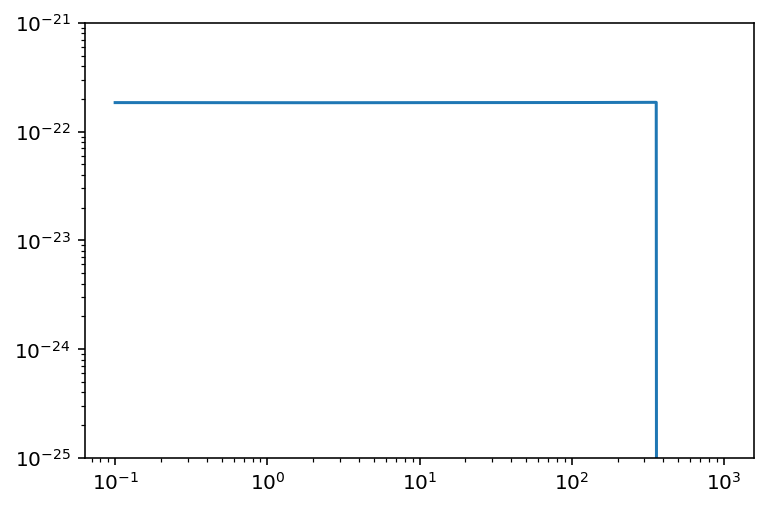

In [131]:
plt.plot(yrls/yr,fluxmx3_single)
plt.ylim(1e-25,1e-21)
plt.xscale('log')
plt.yscale('log')

In [211]:
try:
    np.arccos(-1.1)
    print('try success')
except:
    print('try failed')

try success


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arccos
  


In [41]:
fluxmx3

RAvgArray([1.844731(36)e-22], dtype=object)

In [12]:
test_ls=[]
for y in yrls:
    test_ls.append(y)

In [79]:
flux = theta_integ(lambda theta: bdmflux(5*yr,theta,10,0.01),nitn=10, neval=10000)
flux

0.0(1.0)e-129

In [13]:
test_ls

[315, 9972, 315360, 9972558, 315360000]

In [81]:
yrls=np.logspace(-5,1,20)*yr

In [85]:
np.int64(yrls)

array([      315,       652,      1350,      2793,      5780,     11960,
           24748,     51207,    105955,    219236,    453629,    938622,
         1942138,   4018553,   8314942,  17204763,  35599031,  73659312,
       152411288, 315360000])

In [32]:
bdmflux(10,0.001,5,10)

9.70551059854033e-25

In [41]:
find_lra(100,0.01,vx(5,0.5))

(8.584364222582893, 0.1200581977021025, 2.354961396943058, False)

In [9]:
test_lra=find_lra(100,0.01,vx(5,0.5))

In [16]:
(np.float64(test_lra[0:3])/kpc2cm)[0]

8.584364222591969

In [42]:
def f(x):
    return x

In [43]:
f([1,2])

[1, 2]

In [47]:
integ = vegas.Integrator([[0, 1]])


In [48]:
result=integ(f, nitn=10, neval=1000)
result

RAvgArray([0.499949(33)], dtype=object)

In [58]:
result[0].mean

0.49994881472893116

Text(0, 0.5, 'y (cm)')

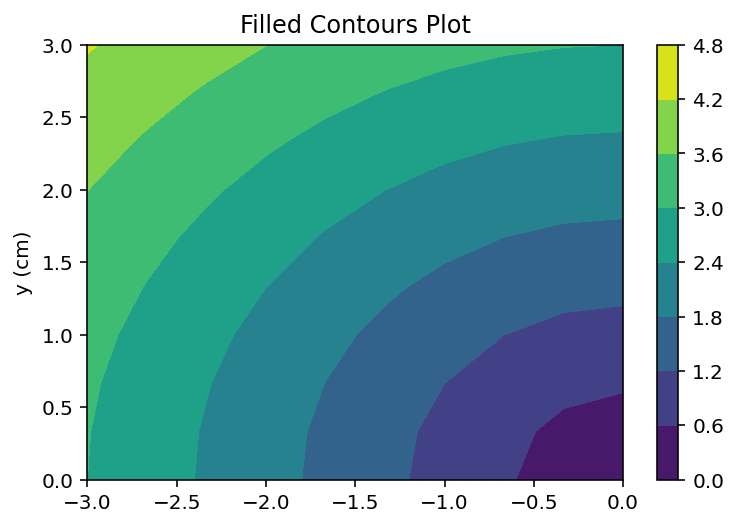

In [18]:
xlist = np.linspace(-3.0, 0, 10)
ylist = np.linspace(0, 3.0, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')

In [12]:
(8.5*kpc2cm/vx(50,0.001)/c-8.5*kpc2cm/c)/yr

5.534194799197742e-06

In [11]:
vx?

Signature: vx(Tx, mx)
Docstring:
The dimensionless DM velocity. To restore the physical unit, just
times the speed of light c

Input
------
Tx: DM kinetic energy
mx: DM mass

Output
------
vx: dimensionless DM velocity
File:      ~/SNvBDM/<ipython-input-4-bf4762ff563f>
Type:      function


In [23]:
testz(xlist[3],ylist[6])

2.8284271247461903

In [50]:
dtest = grad(test)

In [51]:
print(dtest(2.0,3.0))

109.196304


In [36]:
def tanh(x):  # Define a function
    y = jnp.exp(2.0 * x)
    return y#(1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))

14.778112


In [71]:
np.float32([5,6,7])

array([5., 6., 7.], dtype=float32)

In [78]:
1e20-(1e20+1)

0.0

In [79]:
(1e20-1e20)+1

1.0

In [9]:
def f(x):
    
    return 2*x

In [10]:
f(1)

2

In [17]:
f(np.array([2])).shape

(1,)